# Аналитика пользователей и маркетинга Яндекс.Афиши <a id="начало"></a>

<h1 id="tocheading">Table of Contents</h1> <a id="оглавление"></a>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Описание проекта <a id="описание"></a>

**Заказчик:** Яндекс.Афиша — онлайн-сервис по продаже билетов на развлекательные мероприятия

**Что исследуем:** поведение пользователей сервиса

**Цель:** оптимизировать маркетинговые затраты

**Задачи**:
+ описать, как люди пользуются продуктом
+ определить, когда они начинают покупать
+ посчитать, сколько денег приносит каждый клиент
+ установить, когда клиент окупается
+ сформулировать рекомендации, куда (источники/платформы) и сколько маркетологам стоит вкладывать денег 

**С какими данными работаем:** Данные с сайта сервиса за период с июня 2017 по конец мая 2018 года
+ данные о посещении сайта
+ выгрузка всех заказов
+ статистика рекламных расходов

**Вопросы заказчика:** <br>
<br>
**Про продукт** <br>
+ Сколько людей пользуются в день, неделю, месяц?
+ Сколько сессий в день?
+ Сколько длится одна сессия?
+ Как часто люди возвращаются?

**Про продажи** <br>
+ Когда люди начинают покупать?
+ Сколько раз покупают за период?
+ Какой средний чек?
+ Сколько денег приносят? (LTV)

**Про маркетинг** <br>
+ Сколько денег потратили? Всего / на каждый источник / по времени
+ Сколько стоило привлечение одного покупателя из каждого источника?
+ На сколько окупились расходы? (ROI)

Как все эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

## Шаг 1. Изучение и предобработка данных <a id="Шаг_1"></a>
[К оглавлению](#оглавление)<br>
[К выводам по шагу](#conclusion1)

In [2]:
# импортируем нужные библиотеки
# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import plotly.express as px

plt.style.use('seaborn') # штоб красиво было
sns.set(style="darkgrid")

import warnings # возникали предупреждения, но код работал
warnings.filterwarnings('ignore') # решил отключить эти предупреждения

pd.options.display.float_format = '{: .2f}'.format

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

**Таблица visits (информация о визитах; 5 столбцов):**
1. Uid — уникальный идентификатор пользователя
2. Device — категория устройства пользователя
3. Start Ts — дата и время начала сессии
4. End Ts — дата и время окончания сессии
5. Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [3]:
# изучаем данные
visits.info()
print('кол-во строк-дубликатов: ', visits.duplicated().sum())
display(visits.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
кол-во строк-дубликатов:  0


,Device,End Ts,Source Id,Start Ts,Uid
242829,desktop,2017-11-24 18:25:00,3,2017-11-24 18:11:00,8393189451775628102
314378,desktop,2018-03-09 17:40:00,5,2018-03-09 17:40:00,14750841810523991671
159434,touch,2017-07-01 20:42:00,5,2017-07-01 20:41:00,16534349970365857715
266880,desktop,2017-08-30 18:25:00,3,2017-08-30 18:14:00,148823570442167395
308935,desktop,2017-11-24 19:58:00,1,2017-11-24 19:58:00,17072923488260032785


В таблице visits нет пропусков и дубликатов. <br>
Столбцы с датой следует привести к нужному типу — datetime <br>
Названия столбцов стоит привести к написанию в нижнем регистре и заменить на более понятные для удобства.

**Таблица orders (информация о визитах; 3 столбца):**
1. Uid — уникальный id пользователя, который сделал заказ
2. Buy Ts — дата и время заказа
3. Revenue — выручка Яндекс.Афиши с этого заказа

In [4]:
# изучаем данные
orders.info()
print('кол-во строк-дубликатов: ', orders.duplicated().sum())
display(orders.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
кол-во строк-дубликатов:  0


,Buy Ts,Revenue,Uid
18418,2017-11-19 17:29:00,5.50,13376340970648834411
18296,2017-11-18 19:38:00,1.65,8800091480405832681
27113,2017-12-30 10:04:00,1.22,399389805487633775
24674,2017-12-18 06:24:00,1.34,14496083422999280642
34648,2018-02-13 20:57:00,0.73,7953376971237044409


В таблице orders нет пропусков и дубликатов. <br>
Столбец с датой следует привести к нужному типу — datetime <br>
Названия столбцов стоит привести к написанию в нижнем регистре для удобства.

**Таблица costs (информация о визитах; 3 столбца):**
1. source_id — идентификатор рекламного источника (является внешним ключом к таблице visits и указывает на тип источника)
2. dt — дата
3. costs — затраты на этот рекламный источник в этот день

In [5]:
# изучаем данные
costs.info()
print('кол-во строк-дубликатов: ', costs.duplicated().sum())
display(costs.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
кол-во строк-дубликатов:  0


,source_id,dt,costs
1864,9,2017-07-19,10.07
1386,4,2018-03-25,241.82
2012,9,2017-12-14,17.03
1210,4,2017-09-30,197.42
2185,10,2017-06-07,18.30


В таблице costs нет пропусков. <br>
Столбец с датой следует привести к нужному типу datetime и заменить название для удобства. <br>

### Замена типов данных и переименование столбцов

[В начало шага](#Шаг_2)

In [6]:
# обработаем столбцы в таблице visits

#переименуем столбцы
visits = visits.rename(columns = {'Start Ts': 'start_session_time',
                                  'End Ts': 'end_session_time',
                                  'Source Id': 'source_id'})

# заменим тип данных
visits['start_session_time'] = pd.to_datetime(visits['start_session_time'])
visits['end_session_time'] = pd.to_datetime(visits['end_session_time'])

# приведем написание названий столбцов к нижнему регистру
visits.columns = visits.columns.str.lower()

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device                359400 non-null object
end_session_time      359400 non-null datetime64[ns]
source_id             359400 non-null int64
start_session_time    359400 non-null datetime64[ns]
uid                   359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [7]:
# обработаем столбцы в таблице orders

#переименуем столбцы
orders = orders.rename(columns = {'Buy Ts': 'order_time'})

# заменим тип данных
orders['order_time'] = pd.to_datetime(orders['order_time'])

# приведем написание названий столбцов к нижнему регистру
orders.columns = orders.columns.str.lower()

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_time    50415 non-null datetime64[ns]
revenue       50415 non-null float64
uid           50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [8]:
# обработаем столбец с датой в таблице costs

#переименуем столбец
costs = costs.rename(columns = {'dt': 'acquisition_day'})

# заменим тип данных
costs['acquisition_day'] = pd.to_datetime(costs['acquisition_day'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id          2542 non-null int64
acquisition_day    2542 non-null datetime64[ns]
costs              2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Подготовка данных для расчета метрик
[В начало шага](#Шаг_2)

Чтобы посчитать метрики нам нужно дополнить таблицы и еще создать новые <br>.
В этом разделе дополнил таблицы visits и orders, а также создадим таблицы со сводной информацией по каждому платящему пользователю и таблицу для расчета времени до первой покупки.

#### Обновим таблицу visits

Добавим к таблице информацию о месяце, неделе и дне каждого визита. <br>
Добавим столбец с продолжительностью сессий. <br>
Добавим столбец с датой и месяцем первого визита. <br>
Рассчитаем возраст каждого пользователя на каждый визит.

Все это будет нужно для:
1. Retention анализа
2. Анализа продолжительности сессий

In [9]:
# получим столбцы с месяцем, неделей и днем визита с помощью типа данных datetime64[X]

# сразу же приведем значени полученных столбцов к формату даты с помощью dt.date -- так они будут лучше отражаться на графиках

visits['month']  = pd.to_datetime(visits.start_session_time.astype('datetime64[M]'))
visits['day']  = pd.to_datetime(visits.start_session_time.astype('datetime64[D]'))
visits['week'] = (pd.to_datetime(visits.day, unit='d')
                           - pd.to_timedelta(visits.day.dt.dayofweek, unit='d'))
visits['day'] = visits['day'].dt.date

# создадим столбец с продолжительностью каждой сессии: вычтем из окончание сессии её начало и сохраним разницу в секундах
visits['duration'] = (visits['end_session_time'] - visits['start_session_time']).dt.total_seconds().astype('int')

# найдем дату первого визита для каждого пользователя
first_visit_date = visits.groupby(['uid'])['day'].min()
first_visit_date.name = 'first_visit_date'

# добавим эту дату к датафрейму visits
visits = visits.merge(first_visit_date, on = 'uid')

# найдем неделю первого визита, чтобы построить понедельний retention отчет
visits['first_visit_date'] = pd.to_datetime(visits['first_visit_date'].astype('datetime64[D]'))

# найдем месяц первого визита, чтобы построить месячный retention отчет
visits['first_visit_month']  = pd.to_datetime(visits['first_visit_date'].astype('datetime64[M]'))

visits['first_visit_date'] = visits['first_visit_date'].dt.date

# посчитаем время жизни когорты в месяцах
visits['lifetime_month'] = visits['month'] - visits['first_visit_month']
visits['lifetime_month'] = visits['lifetime_month'] / np.timedelta64(1,'M')
visits['lifetime_month'] = visits['lifetime_month'].astype('int')

visits['first_visit_month'] = visits['first_visit_month'].dt.date

visits.sample(10)

,device,end_session_time,source_id,start_session_time,uid,month,day,week,duration,first_visit_date,first_visit_month,lifetime_month
354857,desktop,2018-04-28 09:22:00,5,2018-04-28 09:20:00,8215362895015939620,2018-04-01,2018-04-28,2018-04-23,120,2018-04-28,2018-04-01,0
353901,touch,2017-10-29 08:12:00,5,2017-10-29 08:11:00,3886545344182627167,2017-10-01,2017-10-29,2017-10-23,60,2017-10-29,2017-10-01,0
121122,desktop,2017-10-05 12:43:00,4,2017-10-05 12:31:00,12221394410210348190,2017-10-01,2017-10-05,2017-10-02,720,2017-10-04,2017-10-01,0
59956,desktop,2018-01-09 13:06:00,4,2018-01-09 13:06:00,18029928596981619206,2018-01-01,2018-01-09,2018-01-08,0,2018-01-09,2018-01-01,0
203535,desktop,2018-05-05 19:42:00,2,2018-05-05 19:16:00,11085902357379694284,2018-05-01,2018-05-05,2018-04-30,1560,2018-04-22,2018-04-01,0
259704,desktop,2018-03-25 16:43:00,4,2018-03-25 16:37:00,14555221234112295996,2018-03-01,2018-03-25,2018-03-19,360,2018-03-25,2018-03-01,0
274842,desktop,2018-01-03 14:38:00,4,2018-01-03 14:05:00,7989746154342920104,2018-01-01,2018-01-03,2018-01-01,1980,2018-01-03,2018-01-01,0
47489,touch,2018-02-27 20:53:00,4,2018-02-27 20:51:00,9144670570366923764,2018-02-01,2018-02-27,2018-02-26,120,2018-02-27,2018-02-01,0
297298,desktop,2017-09-03 13:48:00,2,2017-09-03 13:46:00,400264295693520780,2017-09-01,2017-09-03,2017-08-28,120,2017-09-03,2017-09-01,0
140808,desktop,2017-10-10 09:23:00,5,2017-10-10 09:17:00,3623815344502748286,2017-10-01,2017-10-10,2017-10-09,360,2017-10-10,2017-10-01,0


Мы получили новый столбец с числовыми значениями duration. <br>
Стоит проверить, есть ли в нем неадкватные значения.

In [10]:
# проверим столбец с продолжительностью сессий
visits['duration'].describe()

count    359400.00
mean        643.03
std         997.13
min       -2760.00
25%         120.00
50%         300.00
75%         840.00
max       42660.00
Name: duration, dtype: float64

В таблице есть очень экстримальные значения: отрицательное время и слишком большое время.

In [11]:
# изучим, что это за сессиии
visits.query('duration < 0 or duration == duration.max()')

,device,end_session_time,source_id,start_session_time,uid,month,day,week,duration,first_visit_date,first_visit_month,lifetime_month
27980,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-01,2018-03-25,2018-03-19,-1920,2017-11-12,2017-11-01,3
59662,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-01,2018-03-25,2018-03-19,-2760,2018-03-19,2018-03-01,0
286202,desktop,2017-12-18 22:43:00,3,2017-12-18 10:52:00,15566184277200431914,2017-12-01,2017-12-18,2017-12-18,42660,2017-12-18,2017-12-01,0


Оказывается, в датасе есть сессии длинной около 12 часов, а также сессии с отрицательными значениями. <br>

Условимся, что сессии дольше 1 часа указывают на случаи, когда пользователь надолго оставил вкладку открытойи не пользоваля сайтом. <br>

In [12]:
# создадим баг-репорт про неправильные логи (строки таблицы visits, в которых время начала сессии позже, чем её окончание)


visists_broken_logs = visits.query('duration < 0')

#далее притворимся, что сохраняем баг-репорт в отдельный файл
# visists_broken_logs_file = visists_broken_logs.to_csv('orders_broken_logs')

#### Создадим талицу с информацией о визитах пользователей

In [13]:
# получим данные о первом визите каждого пользователя
users_info = (visits
                     .sort_values(by = ['uid', 'start_session_time']) # сортируем таблицу по возрастанию id и времени первой сессии
                     .groupby('uid')
                     .agg(
                         {
                             'start_session_time' : 'first', # дата и время первой сессии
                             'source_id': 'first', # источник первой сессии - он же источник привлечения пользователя
                             'device': 'first'} # тип устройства, с которого совершена первая сессия
                         ).reset_index()
                )

# обновим название столбцов в отчете о первом визите пользователя, который построили раньше
users_info = users_info.rename(columns = {'start_session_time': 'first_visit_time'})

#создадим столбец с месяцем первого визита
users_info['acquisition_month'] = users_info['first_visit_time'].astype('datetime64[M]').dt.date

# создадим столбец с днем первого визита - он же день привлечения пользователя
users_info['acquisition_day'] = users_info['first_visit_time'].dt.date

users_info.head()

,uid,first_visit_time,source_id,device,acquisition_month,acquisition_day
0,11863502262781,2018-03-01 17:27:00,3,touch,2018-03-01,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2,touch,2018-02-01,2018-02-06
2,297729379853735,2017-06-07 18:47:00,3,desktop,2017-06-01,2017-06-07
3,313578113262317,2017-09-18 22:49:00,2,desktop,2017-09-01,2017-09-18
4,325320750514679,2017-09-30 14:29:00,5,desktop,2017-09-01,2017-09-30


In [14]:
users_info = (users_info
                  .reset_index()
                  # сгруппируем полученную таблицу по id источника трафика и месяцу привлечения
                  .set_index(['source_id', 'acquisition_day']) 
                  # соеденим таблицу с таблицей расходов по источнику и дню привлечения / расхода маркетиногвого бюджета
                  .join(costs.set_index(['source_id', 'acquisition_day']), how = 'left')
             )


users_info = users_info.reset_index().set_index('uid')[['first_visit_time', 'acquisition_day', 'acquisition_month', 'source_id', 'device']]
users_info = users_info.reset_index()
users_info.head()

,uid,first_visit_time,acquisition_day,acquisition_month,source_id,device
0,469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop
1,618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch
2,1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop
3,1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop
4,1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop


***

#### Создадим отчет по покупателям (пользователи, которые купили)

Этот отчет будет постороен только по тем, посетителям сайта, которые совершили покупку. <br>

Для каждого из них найдем:
1. время первого заказа
2. месяц первого заказа
3. день первого визита (день привлечения)
4. источник, по которому пользователь попал на сайт в первый раз
5. тип устройства, с которого пользователь первый раз перешел на сайт
6. стоимость привлечения

In [15]:
buyers_info = (orders
                     .groupby('uid')
                     .agg({'order_time' : 'min', 'revenue': 'sum'}) # тип устройства, с которого совершена первая сессия
                     .reset_index()
                )

buyers_info.head()

,uid,order_time,revenue
0,313578113262317,2018-01-03 21:51:00,0.55
1,1575281904278712,2017-06-03 10:13:00,3.05
2,2429014661409475,2017-10-11 18:33:00,73.33
3,2464366381792757,2018-01-28 15:54:00,2.44
4,2551852515556206,2017-11-24 10:14:00,10.99


In [16]:
buyers_info = buyers_info.merge(users_info[['uid', 'acquisition_day', 'acquisition_month', 'source_id', 'device']], how = 'left')

buyers_info = buyers_info.rename(columns = {'order_time': 'first_order_time'})

buyers_info.head()

,uid,first_order_time,revenue,acquisition_day,acquisition_month,source_id,device
0,313578113262317,2018-01-03 21:51:00,0.55,2017-09-18,2017-09-01,2,desktop
1,1575281904278712,2017-06-03 10:13:00,3.05,2017-06-03,2017-06-01,10,touch
2,2429014661409475,2017-10-11 18:33:00,73.33,2017-10-11,2017-10-01,3,desktop
3,2464366381792757,2018-01-28 15:54:00,2.44,2018-01-27,2018-01-01,5,desktop
4,2551852515556206,2017-11-24 10:14:00,10.99,2017-11-24,2017-11-01,5,desktop


In [17]:
#buyers_info['first_order_month'] = pd.to_datetime(buyers_info['first_order_time'].astype('datetime64[M]'))
buyers_info['first_order_day'] = pd.to_datetime(buyers_info['first_order_time'].astype('datetime64[D]'))
#buyers_info['first_visit_month'] = pd.to_datetime(buyers_info['first_visit_time'].astype('datetime64[M]'))
#buyers_info['acquisition_day'] = buyers_info['first_visit_time'].dt.date

buyers_info.head()

,uid,first_order_time,revenue,acquisition_day,acquisition_month,source_id,device,first_order_day
0,313578113262317,2018-01-03 21:51:00,0.55,2017-09-18,2017-09-01,2,desktop,2018-01-03
1,1575281904278712,2017-06-03 10:13:00,3.05,2017-06-03,2017-06-01,10,touch,2017-06-03
2,2429014661409475,2017-10-11 18:33:00,73.33,2017-10-11,2017-10-01,3,desktop,2017-10-11
3,2464366381792757,2018-01-28 15:54:00,2.44,2018-01-27,2018-01-01,5,desktop,2018-01-28
4,2551852515556206,2017-11-24 10:14:00,10.99,2017-11-24,2017-11-01,5,desktop,2017-11-24


In [18]:
buyers_info = (buyers_info
                  # сгруппируем полученную таблицу по источнику трафика и дню привлечения (дню первого визита)
                  .set_index(['source_id', 'acquisition_day']) 
                  # соеденим таблицу с таблицей расходов по источнику и дню привлечения
                  #(день расхода маркетиногвого бюджета в таблице costs)
                  .join(costs.set_index(['source_id', 'acquisition_day']), how = 'left')
             )


buyers_info.head()

uid    first_order_time  revenue  \
source_id acquisition_day                                                     
1         2017-06-01        469568501030474895 2017-09-11 00:06:00    70.69   
          2017-06-01       1074355127080856382 2017-06-01 09:23:00     0.37   
          2017-06-01       1292867924428534308 2017-06-01 16:47:00     4.28   
          2017-06-01       2050423809815667474 2017-06-01 10:38:00     8.31   
          2017-06-01       3520273333047097992 2017-06-01 20:35:00     0.24   

                          acquisition_month   device first_order_day  costs  
source_id acquisition_day                                                    
1         2017-06-01             2017-06-01  desktop      2017-09-11  75.20  
          2017-06-01             2017-06-01  desktop      2017-06-01  75.20  
          2017-06-01             2017-06-01  desktop      2017-06-01  75.20  
          2017-06-01             2017-06-01  desktop      2017-06-01  75.20  
          2017-06-01             2017-06-01  desktop      2017-06-01  75.20

In [19]:
# сделаем таблицу, в которой по каждому источнику трафика на каждый день отобразим
# кол-во привлеченных пользователей, которые сделали заказ
# маркетинговые расходы
# стоимость привлечения платещего пользователя

customer_cost = (buyers_info
                 .groupby(['source_id', 'acquisition_day']) # группируем: для каждого источника отобразим каждый день
                 .agg({'uid': 'nunique', 'costs': 'max'}) # считаем кол-во уникальных пользователей и определяем сумму расходов
                 .rename(columns = {'uid': 'buyers'})
            )
# далее считаем среднюю стоимость одного привлеченного пользователя
customer_cost['cac'] = customer_cost['costs'] / customer_cost['buyers']

customer_cost.head()

buyers  costs   cac
source_id acquisition_day                     
1         2017-06-01           24  75.20  3.13
          2017-06-02           12  62.25  5.19
          2017-06-03            8  36.53  4.57
          2017-06-04            6  55.00  9.17
          2017-06-05           20  57.08  2.85

In [20]:
# добавим стоимост ьпривлечения каждого клиента
buyers_info = buyers_info.join(customer_cost['cac'], how = 'left')

#сбросим индекс
buyers_info = buyers_info.reset_index()

# удалим ненужные столбцы
buyers_info = buyers_info.drop(columns=['first_order_time'])

buyers_info.head()

,source_id,acquisition_day,uid,revenue,acquisition_month,device,first_order_day,costs,cac
0,1,2017-06-01,469568501030474895,70.69,2017-06-01,desktop,2017-09-11,75.20,3.13
1,1,2017-06-01,1074355127080856382,0.37,2017-06-01,desktop,2017-06-01,75.20,3.13
2,1,2017-06-01,1292867924428534308,4.28,2017-06-01,desktop,2017-06-01,75.20,3.13
3,1,2017-06-01,2050423809815667474,8.31,2017-06-01,desktop,2017-06-01,75.20,3.13
4,1,2017-06-01,3520273333047097992,0.24,2017-06-01,desktop,2017-06-01,75.20,3.13


#### Дополним таблицу orders

Добавим время и месяц первого заказа. <br>
Добавим столбец с месяцем каждого заказа. <br>
Добавим источник и устройство первого посещения сайта для каждого пользователя. <br>
Добавим дату привлечения каждого пользователя.

Все это будет нужно для:
1. Когортного анализа ROI и LTV
2. Анализа доходов

In [21]:
# создадим столбец с датой первого заказа в таблице с заказами

first_order_date_by_customers = orders.groupby('uid')['order_time'].min()
first_order_date_by_customers.name = 'first_order_time'
orders = orders.join(first_order_date_by_customers, on='uid')

# получим данные о первом заказе
first_orders = (orders
                        .sort_values(by = ['uid', 'order_time']) # сортируем таблицу заказов по убыванию даты заказов
                        .groupby('uid')                # для каждого пользователя
                        .agg({'order_time' : 'first'}) # нахожим дату первого заказа
               )
first_orders.head()

#создадим столбец с месяцем первого заказа
orders['first_order_month'] = orders['first_order_time'].astype('datetime64[M]').dt.date

#создадим столбец с месяцем каждого заказа
orders['order_month'] = orders['order_time'].astype('datetime64[M]').dt.date


# к каждому заказу пришьем
# источник трафика от первого визита пользователя
# и устройство первого визита
# месяц первого визита
# cтоимость привлечения
orders = orders.merge(buyers_info[['uid', 'acquisition_month', 'source_id', 'device', 'cac']],  how='left', on = 'uid')


orders.head()

,order_time,revenue,uid,first_order_time,first_order_month,order_month,acquisition_month,source_id,device,cac
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01,1,desktop,3.13
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01,2,desktop,4.73
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01,2,desktop,4.73
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01,2,desktop,4.73
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01,3,desktop,7.60


***

#### Создадим таблицу для расчета времени до покупки

In [22]:
# получим данные о первом заказе
first_orders = (orders
                        .groupby('uid')                # для каждого пользователя
                        .agg({'order_time' : 'min'}) # нахожим дату первого заказа
               )
first_orders.head()

,order_time
uid,
313578113262317,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00
2464366381792757,2018-01-28 15:54:00
2551852515556206,2017-11-24 10:14:00


In [23]:
# создаим отчет о первых визитах и покупках каждого пользователя

# к отчету о первом визите каждого пользователя добавим дату его первого заказа и переименуем столбцы
time_report = users_info.merge(first_orders, on = 'uid')
time_report = time_report.rename(columns = {'start_session_time': 'first_visit_time',
                                  'order_time': 'first_order_time',
                                  })



# создадим столбцы с днями первого визита и первого заказа
# а также с количеством дней и минут между первым визитом и покупкой

time_report['first_visit_day'] = time_report['first_visit_time'].astype('datetime64[D]').dt.date
time_report['first_order_day'] = time_report['first_order_time'].astype('datetime64[D]').dt.date
time_report['days_bf_order'] = (time_report['first_order_day'] - time_report['first_visit_day']).dt.days
time_report['minutes_bf_order'] = (time_report['first_order_time'] - time_report['first_visit_time']).dt.total_seconds() / 60

#дропнем лишние столбцы
time_report = time_report.drop(columns=['first_visit_time', 'source_id', 'acquisition_month', 'acquisition_day', 'first_order_time'])

time_report.head()

,uid,device,first_visit_day,first_order_day,days_bf_order,minutes_bf_order
0,469568501030474895,desktop,2017-06-01,2017-09-11,102,146556.00
1,1074355127080856382,desktop,2017-06-01,2017-06-01,0,2.00
2,1292867924428534308,desktop,2017-06-01,2017-06-01,0,234.00
3,2050423809815667474,desktop,2017-06-01,2017-06-01,0,2.00
4,3520273333047097992,desktop,2017-06-01,2017-06-01,0,27.00


In [24]:
# проверим полученные значения времени на адекватность
time_report[['days_bf_order', 'minutes_bf_order']].describe()

,days_bf_order,minutes_bf_order
count,36523.00,36523.00
mean,16.90,24340.18
std,47.07,67784.77
min,0.00,0.00
25%,0.00,4.00
50%,0.00,16.00
75%,2.00,2897.00
max,363.00,523144.00


В датасете встречаются случаи, где первый заказ случился раньше, чем первый визит.

Очистим датасет от таких строк.

In [25]:
# обновим репорт: исключим записи, где кол-во дней и минут до заказа меньше нуля
time_report = time_report.query('days_bf_order >= 0 and minutes_bf_order >=0')

# посмотрим, как изменились значения
time_report[['days_bf_order', 'minutes_bf_order']].describe()

,days_bf_order,minutes_bf_order
count,36523.00,36523.00
mean,16.90,24340.18
std,47.07,67784.77
min,0.00,0.00
25%,0.00,4.00
50%,0.00,16.00
75%,2.00,2897.00
max,363.00,523144.00


Теперь в таблице нет отрицательных значений и её можно использовать для отчета по времени до покупки.

***

#### Выводы <a id="conclusion1"></a>
[В начало шага](#Шаг_1)

Во всех трех таблицах привели названия столбцов к более удобным и понятным. <br>
Столбы с датами привели к типу datetime.

Создали две дополнительные таблицы:
1. time_report — для анализа времени до первой покупки
2. users_info, где для каждого посетителя указали стоимость привлечения, канал привлечение и устройство первого визита

В таблице visits создали столбец duration для анализа продолжительности сессий.

В таблице orders создали столбцы с датой первого заказа и месяцем для каждого заказа (в дальнейшем они пригодятся для когортного анализа и анализа помесячной выручки)

***

## Шаг 2. Расчет метрик <a id="Шаг_2"></a>
[К оглавлению](#оглавление)<br>
[К выводам по шагу](#conclusion2)

Чек-лист посчитанных метрик





Отобразить на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

### Продуктовые метрики

**Чек-лист:**
- [x] Сколько людей пользуются в день, неделю, месяц?
- [x] Сколько сессий в день?
- [x] Сколько длится одна сессия?
- [x] Как часто люди возвращаются?
- [x] Отображено на графиках, как метрики отличаются по устройствам
- [x] Отображено на графиках, как метрики отличаются рекламным источникам
- [x] Отображено на графиках, как метрики меняются во времени

#### DAU, WAU, MAU, средняя продолжительность сессий, среднее кол-во сессий <a id="howmuch"></a>

In [26]:
#считаем метрики пользовательской активности

# считаем, сколько пользователей в среднем за день заходят Яндекс.Афишу
dau_total = visits.groupby(['day']).agg({'uid': 'nunique'})

# считаем, сколько пользователей в среднем за неделю заходят Яндекс.Афишу
wau_total = visits.groupby(['week']).agg({'uid': 'nunique'})

# считаем, сколько пользователей в среднем за месяц заходят Яндекс.Афишу
mau_total = visits.groupby(['month']).agg({'uid': 'nunique'})

print("\n" + 'Daily Active Users:', int(dau_total.mean()), 'человек' + "\n")
print("\n" + 'Weekly Active Users:', int(wau_total.mean()), 'человек' + "\n")
print("\n" + 'Montly Active Users:', int(mau_total.mean()), 'человек' + "\n")


Daily Active Users: 907 человек


Weekly Active Users: 5716 человек


Montly Active Users: 23228 человек



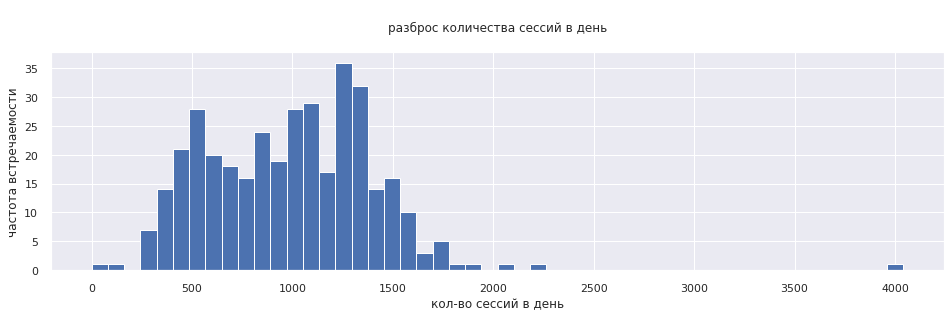


Среднее кол-во сессий в день: 987 



In [27]:
visits.groupby('day').agg({'uid': 'count'}).uid.hist(bins = 50, figsize = (16,4))
plt.xlabel('кол-во сессий в день')
plt.ylabel('частота встречаемости')
plt.title("\n" + 'разброс количества сессий в день' + "\n")
plt.show()
print("\n" + 'Среднее кол-во сессий в день:', int(visits.groupby('day').agg({'uid': 'count'}).uid.mean()), "\n")

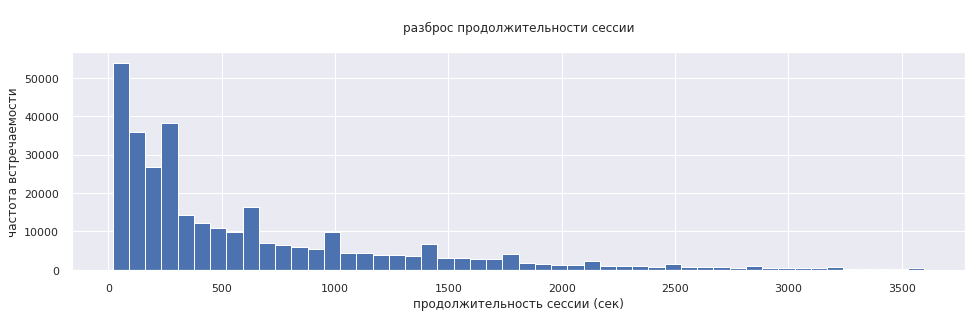


Средняя продолжительность сессии: 618 cекунд или 10 минут


Типичная (самая частая) продолжительность сессии: 60 cекунд



In [28]:
visits.query('duration > 0 and duration <= 3600').duration.hist(bins = 50, figsize = (16,4))
plt.xlabel('продолжительность сессии (сек)')
plt.ylabel('частота встречаемости')
plt.title("\n" + 'разброс продолжительности сессии' + "\n")
plt.show()

print("\n" + 'Средняя продолжительность сессии:',
      int(visits.query('duration > 0 and duration <= 3600').duration.mean()),
      'cекунд или', int(visits.query('duration > 0 and duration <= 3600').duration.mean()/60), 'минут'  + "\n")

print("\n" + 'Типичная (самая частая) продолжительность сессии:',
      int(visits.query('duration > 0 and duration <= 3600').duration.mode()), 'cекунд' + "\n")

В среднем за один месяц Яндекс.Афишу посещают 23 тысячи активных пользователей. <br>
В среднем за неделю — 5,6 тысяч. <br>
В день — 898. <br>

В среднем за день на сайте бывает 970 сессий продолжительности около 9 минут. <br>

Чаще всего на сайте проводят около 1 минуты.
1 минута на то, чтобы найти мероприятие и купить билеты — это очень быстро. Вероятно такое среднее время сложилось из-за пользователей, которые заходят "только посмотерть", либо из пользователей, которые знают, зачем приходят, и быстро покупают билеты.

#### Как часто возвращаются пользователи? Retention rate и Sticky factor

In [29]:
# узнаем, сколько в среднем сессий приходится на одного пользователя в месяц, чтобы узнать, как часто возвращаются пользователи

# сначала сгруппируем данные по году и месяцу и посчитаем кол-во уникальных пользователей и их визитов
sessions_per_user = visits.groupby(['month']).agg({'uid': ['count','nunique']}).reset_index()
sessions_per_user.columns = ['month', 'n_sessions', 'n_users']

# посчитаем среднее кол-во сессий на пользователя за каждый месяц
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
display(sessions_per_user.head(20))

# посчитаем среднее кол-во сессий на пользователя в месяц
print('\n' + 'Среднее кол-во сессий на одного пользователя в месяц:',
          round(sessions_per_user.n_sessions.sum() / sessions_per_user.n_users.sum(), 1)) 

,month,n_sessions,n_users,sess_per_user
0,2017-06-01,16505,13259,1.24
1,2017-07-01,17828,14183,1.26
2,2017-08-01,14355,11631,1.23
3,2017-09-01,23907,18975,1.26
4,2017-10-01,37903,29692,1.28
5,2017-11-01,43969,32797,1.34
6,2017-12-01,41983,31557,1.33
7,2018-01-01,36939,28716,1.29
8,2018-02-01,37182,28749,1.29
9,2018-03-01,35679,27473,1.30



Среднее кол-во сессий на одного пользователя в месяц: 1.3


In [30]:
# изучим также месячный sticky factor Яндекс.Афиши

sticky_mau = dau_total.mean() / mau_total.mean() * 100
sticky_mau
print('\n', round(sticky_mau[0], 1), '— доля уникальных пользователей, которые повторно зашли на сайт в течение месяца')


 3.9 — доля уникальных пользователей, которые повторно зашли на сайт в течение месяца


Повторно на сайт заходят только 4% от всех месячных посетителей. <br>
Это низкий Sticky Factor, а значит пользователи заходят на сайт Яндекс.Афиши не регулярно.


Средний пользователь проводит в приложении максимум 1 сессию. <br>
Это значит, что после своей первой сессии в конкретный месяц пользователи редко возвращаются на сайт в течение этого же месяца.

Однако для сервиса-афиши такие показатели кажутся адекватными: далеко не все люди посещают концерты и прочие мероприятия каждую неделю.

Далее изучим retention rate в разных когортах пользователей в динамике по месяцам.

У нас есть таблица visits, которую мы подготовили для когортного анализа Retention rate. <br>
Воспользуемся ей.

In [31]:
#Сгруппируем данные по когорте и lifetime.
#Посчитаем для каждой когорты количество активных пользователей на определённый период жизни
month_visits_cohorts = visits.groupby(['first_visit_month','lifetime_month']).agg({'uid':'nunique'}).reset_index() 

Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждую следующую неделю. <br> 
Найдём исходное количество пользователей в когортах. Возьмём их число на нулевой месяц.

In [32]:
month_cohort_size = month_visits_cohorts[month_visits_cohorts['lifetime_month'] == 0][['first_visit_month','uid']]
month_cohort_size = month_cohort_size.rename(columns={'uid':'cohort_users'})
month_cohort_size

,first_visit_month,cohort_users
0,2017-06-01,13259
10,2017-07-01,13140
19,2017-08-01,10181
28,2017-09-01,16704
34,2017-10-01,25977
41,2017-11-01,27248
46,2017-12-01,25268
51,2018-01-01,22624
55,2018-02-01,22197
58,2018-03-01,20589


In [33]:
month_visits_cohorts = month_visits_cohorts.merge(month_cohort_size,on='first_visit_month')
month_visits_cohorts['retention'] = month_visits_cohorts['uid']/month_visits_cohorts['cohort_users'] 
month_visits_cohorts.head()

,first_visit_month,lifetime_month,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.00
1,2017-06-01,2,713,13259,0.05
2,2017-06-01,3,814,13259,0.06
3,2017-06-01,4,909,13259,0.07
4,2017-06-01,5,947,13259,0.07


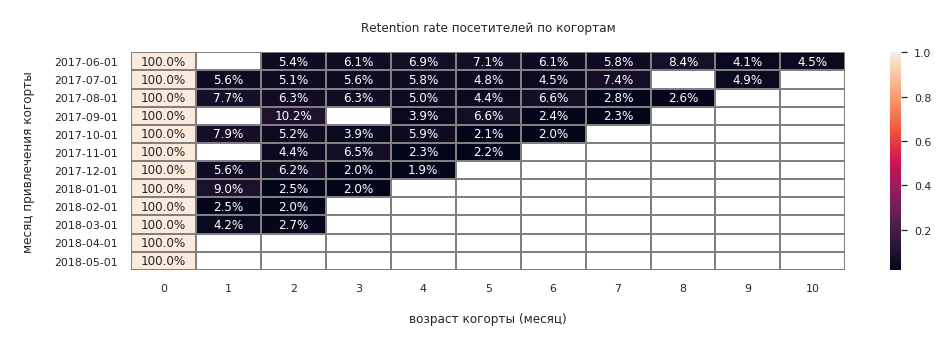

In [34]:
retention_pivot = month_visits_cohorts.pivot_table(index='first_visit_month',
                                      columns='lifetime_month',
                                      values='retention',
                                      aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(16, 4))
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

plt.title("\n" + 'Retention rate посетителей по когортам' + "\n")
plt.ylabel("\n" + 'месяц привлечения когорты' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

#### Как Renetion rate различается по типам устройств?

#### Как Renetion rate различается по источникам трафика?

### Продуктовые метрики в динамике

#### Как менялись средняя продолжительность сессий от месяца к месяцу?

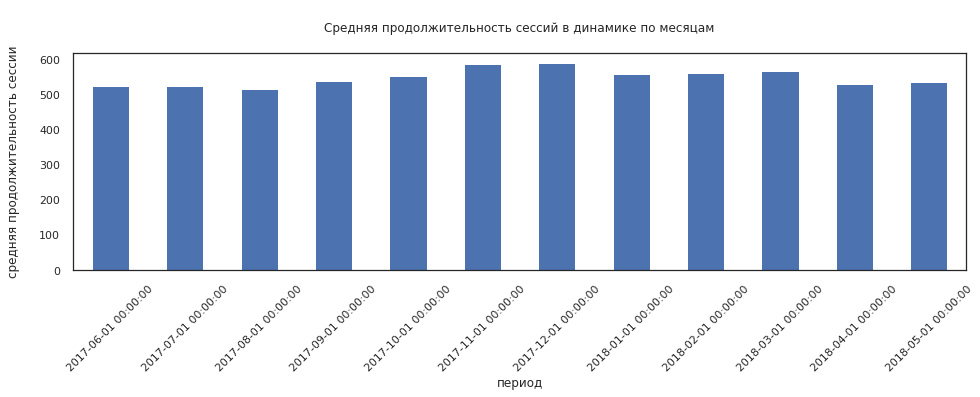

In [35]:
# средняя продолжительность сессий
(visits
     .query('duration >= 0 and duration <= 3600')
     .groupby('month')['duration'].mean()
     .plot(kind = 'bar', figsize = (16, 4), rot = 45)
)

plt.title("\n" + 'Средняя продолжительность сессий в динамике по месяцам' + "\n")
plt.xlabel('период')
plt.ylabel("средняя продолжительность сессии" + "\n")
plt.show()

#### Как менялось кол-во сессий от месяца к месяцу?

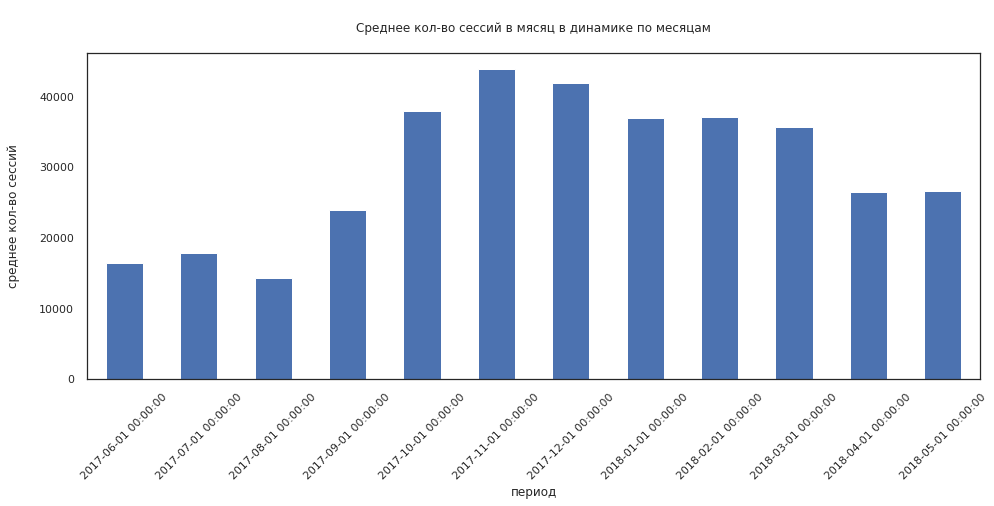

In [36]:
# средняя продолжительность сессий
visits.groupby('month')['start_session_time'].count().plot(kind = 'bar', figsize = (16, 6), rot = 45)

plt.title("\n" + 'Среднее кол-во сессий в мясяц в динамике по месяцам' + "\n")
plt.xlabel('период')
plt.ylabel("среднее кол-во сессий" + "\n")
plt.show()

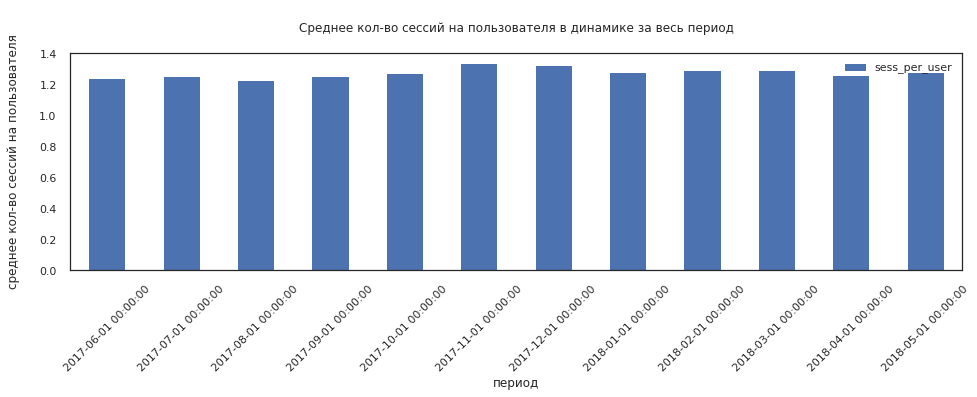

In [37]:
# как менялось среднее кол-во сессий в месяц на пользователя
sessions_per_user.plot(kind = 'bar',
                       x = 'month',
                       y = 'sess_per_user',
                       rot = 45,
                       figsize = (16, 4))


plt.title("\n" + 'Среднее кол-во сессий на пользователя в динамике за весь период' + "\n")
plt.xlabel('период')
plt.ylabel("среднее кол-во сессий на пользователя" + "\n")
plt.show()

#### Как менялась активная месячная аудитория (MAU) от месяца к месяцу?

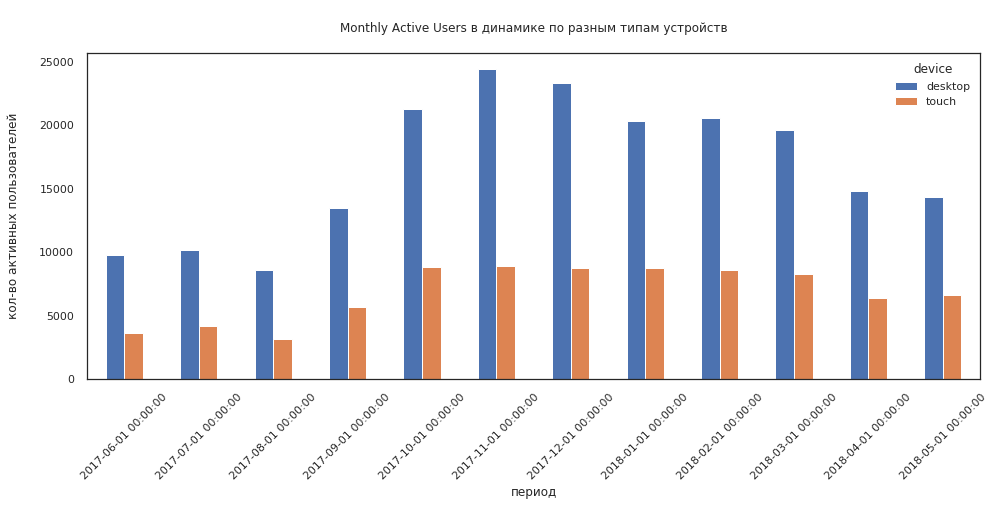

In [38]:
# посмотрим, как меняется MAU на разных типах устройств
(visits
         .pivot_table(
                        index = 'month',
                        columns = 'device',
                        values = 'uid',
                        aggfunc = 'nunique'
                      )
         .plot(kind = 'bar',
                 figsize = (16, 6),
                 rot = 45
              )
)
plt.title("\n" + 'Monthly Active Users в динамике по разным типам устройств' + "\n")
plt.xlabel('период')
plt.ylabel("кол-во активных пользователей" + "\n")
plt.show()

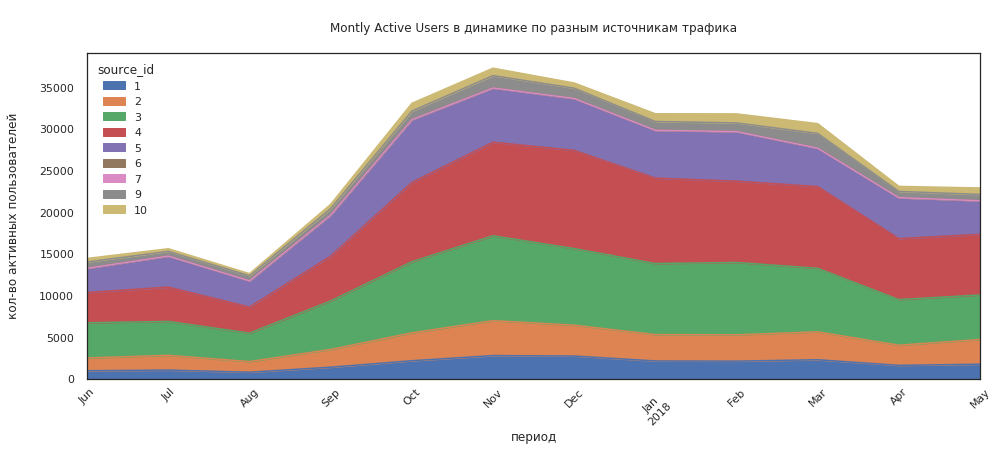

In [39]:
# посмотрим, как меняется MAU в разрезе разных источников трафика
(visits
         .pivot_table(
                        index = 'month',
                        columns = 'source_id',
                        values = 'uid',
                        aggfunc = 'nunique'
                      )
         .plot.area(
                 figsize = (16, 6),
                 rot = 45
              )
)
plt.title("\n" + 'Montly Active Users в динамике по разным источникам трафика' + "\n")
plt.xlabel('период')
plt.ylabel("кол-во активных пользователей" + "\n")
plt.show()

#### Как средняя продолжительность различается по устройствам?


Среднее время сессии на desktop за месяц: 10 мин


Среднее время сессии на touch за месяц: 7 мин



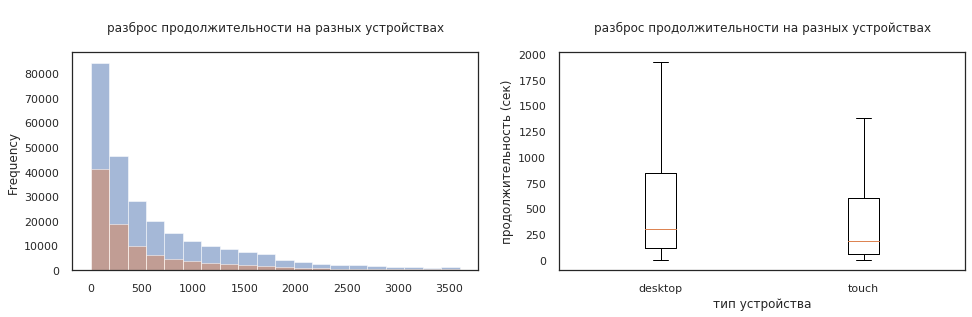

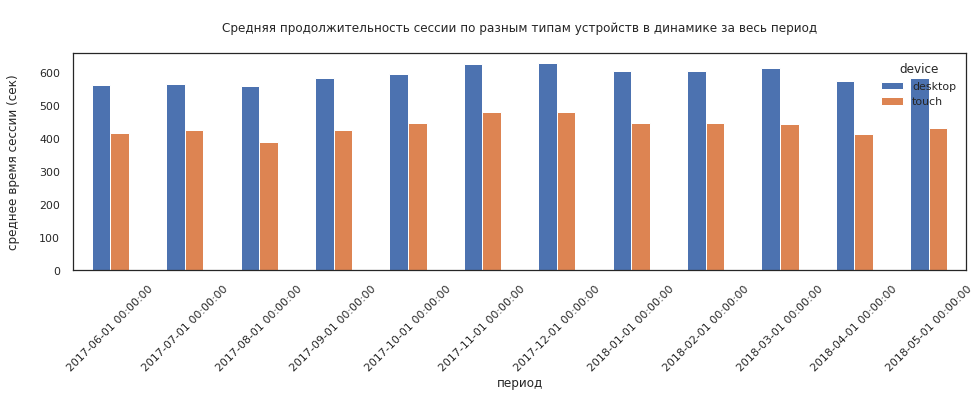

In [40]:
# создадим сводную таблицу
mean_duration_by_device = (visits
                               .query('duration >= 0 and duration <= 3600')
                               .pivot_table(values = 'duration',
                                            index = 'month',
                                            columns = 'device',
                                            aggfunc ='mean')
                          )


# построим график для сравнения среднего времени по устройствам
print("\n" + 'Среднее время сессии на desktop за месяц:', round(mean_duration_by_device.desktop.mean() / 60), 'мин' + "\n")
print("\n" + 'Среднее время сессии на touch за месяц:', round(mean_duration_by_device.touch.mean() / 60), 'мин' + "\n")
fig, (ax, ax2) = plt.subplots(ncols=2, figsize = (16, 4))
    
visits.query('device == "desktop" and duration >= 0 and duration <= 3600')['duration'].plot(kind = 'hist', alpha=0.5, bins = 20, ax = ax,)
visits.query('device == "touch" and duration >= 0 and duration <= 3600')['duration'].plot(kind = 'hist', alpha=0.5, bins = 20, ax = ax, title = ("\n" + 'разброс продолжительности на разных устройствах' + "\n"))
# plt.xlabel()
# plt.ylabel('частота встречаимости')
# plt.title('разброс продолжительности на разных устройствах')

plt.boxplot([visits.query('device == "desktop" and duration >= 0 and duration <= 3600')['duration'],
                   visits.query('device == "touch" and duration >= 0 and duration <= 3600')['duration']],
                   labels = ['desktop', 'touch'],
                   showfliers = False,
                  )
plt.xlabel('тип устройства')
plt.ylabel('продолжительность (сек)')
plt.title("\n" + 'разброс продолжительности на разных устройствах' + "\n")
plt.show()


# посмотрим на данные в динамике
mean_duration_by_device.plot(kind = 'bar',rot = 45,figsize = (16, 4))
plt.title("\n" + 'Средняя продолжительность сессии по разным типам устройств в динамике за весь период' + "\n")
plt.xlabel('период')
plt.ylabel("среднее время сессии (сек)" + "\n")
plt.show()

#### Как средняя продолжительность различается по источникам трафика?

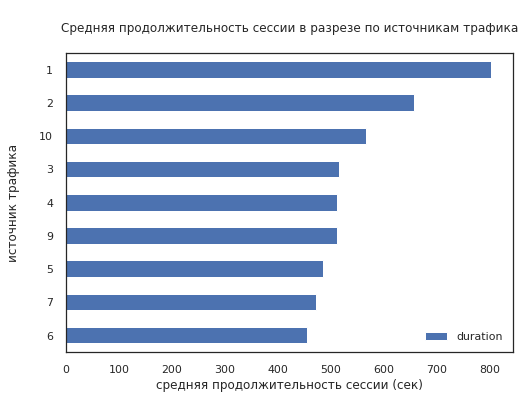

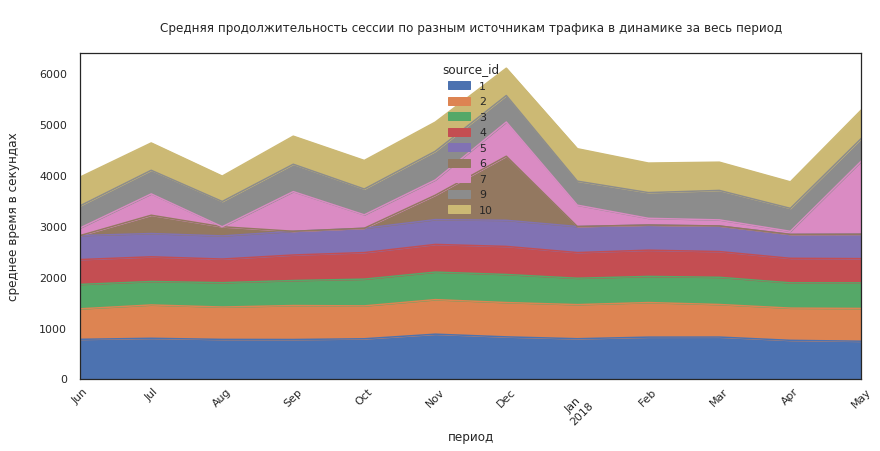

In [41]:
# сгруппируем данные по источнику трафика
mean_duration_by_source = (visits
                                   .query('duration >= 0 and duration <= 3600')
                                   .groupby(['source_id'])
                                   .agg({'duration': 'mean'})
                                   .sort_values(by = 'duration', ascending = True))

# построим график
mean_duration_by_source.plot(kind = 'barh')
plt.title("\n" + 'Средняя продолжительность сессии в разрезе по источникам трафика' + "\n")
plt.xlabel('средняя продолжительность сессии (сек)')
plt.ylabel("источник трафика" + "\n")
plt.show()

# посмотрим на данные в динамике
(visits
 .query('duration >= 0 and duration <= 3600')
 .pivot_table(values = 'duration',
              index = 'month',
              columns = 'source_id',
              aggfunc ='mean')
 .plot.area(figsize = (14, 6), rot = 45)
)
plt.title("\n" + 'Средняя продолжительность сессии по разным источникам трафика в динамике за весь период' + "\n")
plt.xlabel('период')
plt.ylabel("среднее время в секундах" + "\n")
plt.show()

Вывады

#### Как кол-во сессий в месяц различается по устройствам?


Среднее кол-во сессий на desktop в месяц: 21881 


Среднее кол-во сессий на touch в месяц: 8069 



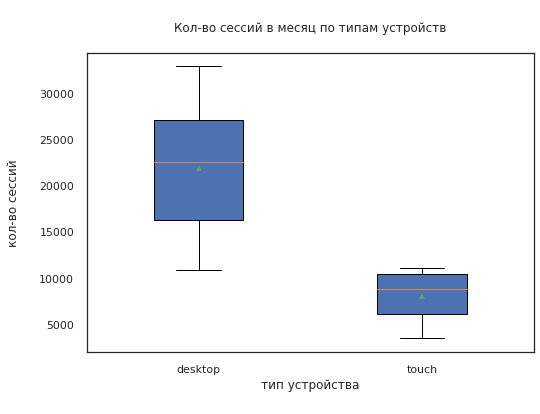

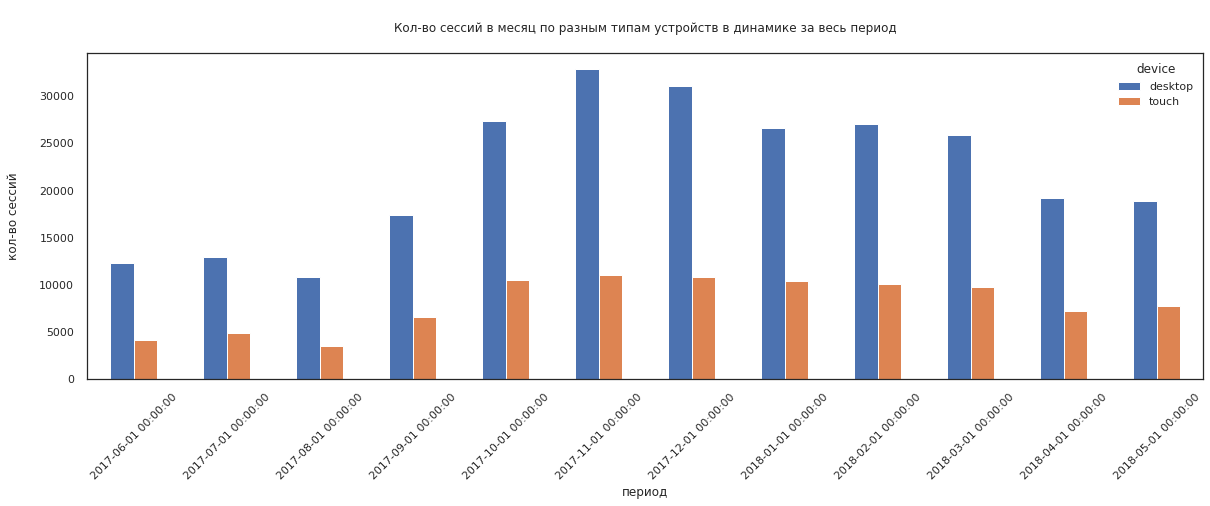

In [42]:
# создадим сводную таблицу
mean_sessions_by_device = visits.pivot_table(
                                        values = 'start_session_time', 
                                        index = 'month',
                                        columns = 'device',
                                        aggfunc ='count')

print("\n" + 'Среднее кол-во сессий на desktop в месяц:', round(mean_sessions_by_device.desktop.mean()), "\n")
print("\n" + 'Среднее кол-во сессий на touch в месяц:', round(mean_sessions_by_device.touch.mean()), "\n")
# построим график для сравнения среднего времени по устройствам
plt.boxplot(
                [mean_sessions_by_device['desktop'],mean_sessions_by_device['touch']],
                   labels = ['desktop', 'touch'],
                    showfliers = False,
                    showmeans = True,
                    autorange = True,
                    widths = 0.4,
                    patch_artist = True
                  )
plt.title("\n" + 'Кол-во сессий в месяц по типам устройств' + "\n")
plt.xlabel("тип устройства" + "\n")
plt.ylabel("кол-во сессий" + "\n")
plt.show()


# посмотрим на данные в динамике
mean_sessions_by_device.plot(kind = 'bar', rot = 45, figsize = (20, 6))
plt.title("\n" + 'Кол-во сессий в месяц по разным типам устройств в динамике за весь период' + "\n")
plt.xlabel('период')
plt.ylabel("кол-во сессий" + "\n")
plt.show()

#### Как кол-во сессий в месяц различается по рекламным источникам?

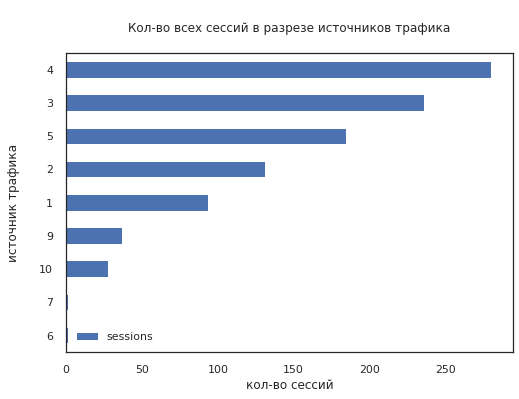

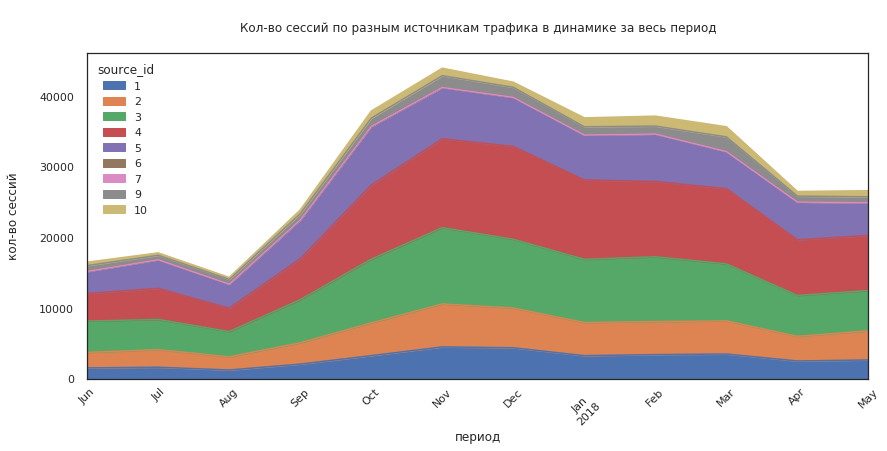

In [43]:
# тоже самое, но по источникам
mean_session_by_source = (visits.groupby(['source_id', 'day']).agg({'uid': 'count'}).sort_values(by = 'uid', ascending = True))
mean_session_by_source = mean_session_by_source.rename(columns = {'uid': 'sessions'})
mean_session_by_source = mean_session_by_source.groupby('source_id').agg({'sessions': 'mean'}).sort_values(by = 'sessions', ascending = True)

mean_session_by_source.plot(kind = 'barh')
plt.title("\n" + 'Кол-во всех сессий в разрезе источников трафика' + "\n")
plt.xlabel('кол-во сессий')
plt.ylabel("источник трафика" + "\n")
plt.show()

# посмотрим на данные в динамике
visits.pivot_table(
                    index = 'month',
                    values = 'start_session_time',
                    columns = 'source_id',
                    aggfunc ='count').plot.area(
                                            figsize = (14, 6),
                                            rot = 45)
plt.title("\n" + 'Кол-во сессий по разным источникам трафика в динамике за весь период' + "\n")
plt.xlabel('период')
plt.ylabel("кол-во сессий" + "\n")
plt.show()

ВЫВАДЫ

### Метрики продаж

**Чек-лист:**
- [x] Когда люди начинают покупать?
- [x] Сколько раз покупают за период?
- [x] Какой средний чек?
- [x] Сколько денег приносят? (LTV)

#### Когда люди начинают покупать?

In [44]:
time_report.head()

,uid,device,first_visit_day,first_order_day,days_bf_order,minutes_bf_order
0,469568501030474895,desktop,2017-06-01,2017-09-11,102,146556.00
1,1074355127080856382,desktop,2017-06-01,2017-06-01,0,2.00
2,1292867924428534308,desktop,2017-06-01,2017-06-01,0,234.00
3,2050423809815667474,desktop,2017-06-01,2017-06-01,0,2.00
4,3520273333047097992,desktop,2017-06-01,2017-06-01,0,27.00


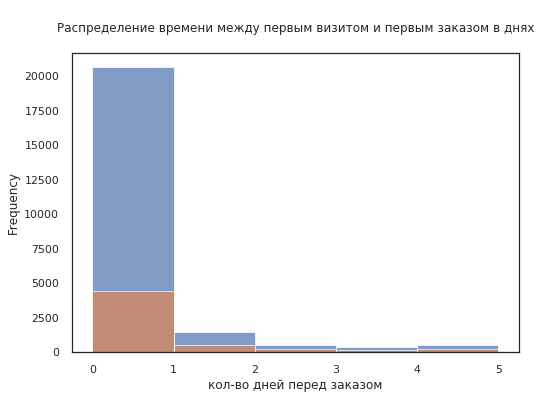

In [45]:
# посмотрим на распределение количества дней перед покупкой сразу в разрезе устройств

time_report.query('device == "desktop"')['days_bf_order'].plot(kind = 'hist', alpha=0.7, bins = 5, range = (0, 5))
time_report.query('device == "touch"')['days_bf_order'].plot(kind = 'hist', alpha=0.7, bins = 5, range = (0, 5))
plt.title("\n" + 'Распределение времени между первым визитом и первым заказом в днях' + "\n")
plt.xlabel('кол-во дней перед заказом')
plt.show()

Большинство пользователей покупают билеты в день своего первого визиты. <br>
При этом большинство покупой совершается с десктопа: таких покупок почти в 5 раз больше, чем с мобильных устройств.


Еще у четверти всех пользователей уходит от 2х дней на решение о покупке. <br>
Из-за таких пользователей среднее время на покупку сильно завышается. <br>

Поэтому изучим, какую долю от всех пользователей составляют те, кто покупает в тот же день, и какое среднее время до покупки у них.

In [46]:
time_report_same_day = time_report.query('first_order_day == first_visit_day')

print("\n" + 'Доля пользователей, которые покупают билеты в свой первый визит:', round(len(time_report_same_day) / len(time_report) * 100), "%")


Доля пользователей, которые покупают билеты в свой первый визит: 69 %


In [47]:
time_report_same_day.minutes_bf_order.describe()

count    25039.00
mean        33.62
std        104.47
min          0.00
25%          2.00
50%          6.00
75%         18.00
max       1372.00
Name: minutes_bf_order, dtype: float64

Описание среднего времени на покупку у тех, кто покупает в тот же день, выглядит более адекватно. <br>
Посмотрим на распределение данных.

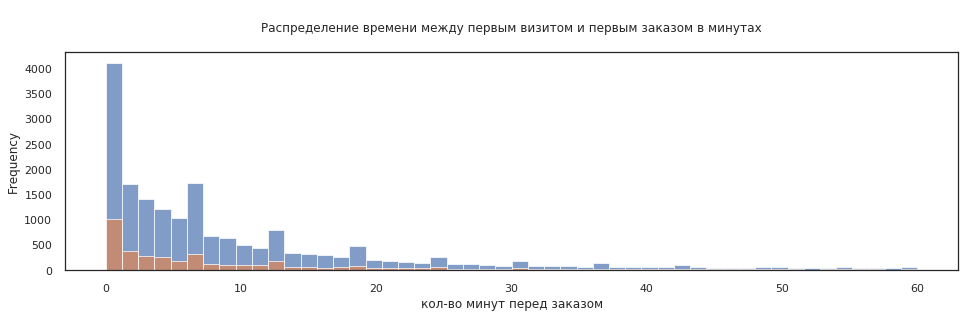

In [48]:
time_report_same_day.query('device == "desktop"')['minutes_bf_order'].plot(kind = 'hist', alpha=0.7, bins = 50, range = (0, 60), figsize = (16,4))
time_report_same_day.query('device == "touch"')['minutes_bf_order'].plot(kind = 'hist', alpha=0.7, bins = 50, range = (0, 60), figsize = (16,4))
plt.title("\n" + 'Распределение времени между первым визитом и первым заказом в минутах' + "\n")
plt.xlabel('кол-во минут перед заказом')
plt.show()

Чаще всего пользователи тратят на покупки меньше минуты! Вероятно такие пользователи уже знают, за чем приходят. <br>
Однако таких пользователей не больше 20-23%. Большинство пользователей (75%) тратят на покупку не более 17 минут.


<br>

**Выводы:**
Большинство пользователей совершают покупку в первый день в течение получаса.

1. 68% посетитилей сайта Яндекс.Афиши совершают покупку в день своего первого визита.
2. 75% из этих пользователей тратят на покупку билета не более 17 минут, а в среднем всем "покупателям первого дня" требуется около получаса.
3. Медианное время до покупки в любой день для всех пользователей сайта — 15 минут.

#### Какой средний чек и как он менялся? 

In [49]:
# сгруппируем отчет по пользователям таким образом,
# чтобы сформировать когорты по месяцу привлечения пользователя
# и для каждой когорты найти кол-во заказов и общую выручку
# и затем рассчитать среднюю выручку с одного пользователя

orders_grouped_by_cohorts = orders.groupby(['acquisition_month','order_month']).agg({'uid': 'nunique', 'order_time':'count','revenue':'sum'})
orders_grouped_by_cohorts = orders_grouped_by_cohorts.rename(columns = {'uid': 'n_buyers', 'order_time': 'orders', 'revenue': 'total_revenue'})
orders_grouped_by_cohorts['avg_check'] = orders_grouped_by_cohorts['total_revenue'] / orders_grouped_by_cohorts['orders']
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index().set_index('acquisition_month')
orders_grouped_by_cohorts.head()

,order_month,n_buyers,orders,total_revenue,avg_check
acquisition_month,,,,,
2017-06-01,2017-06-01,2023,2354,9557.49,4.06
2017-06-01,2017-07-01,231,387,2664.58,6.89
2017-06-01,2017-08-01,129,273,1464.69,5.37
2017-06-01,2017-09-01,188,442,3882.09,8.78
2017-06-01,2017-10-01,257,516,3940.59,7.64


#### Средний чек по сайту

Изучим распределение размеров среднего чека.

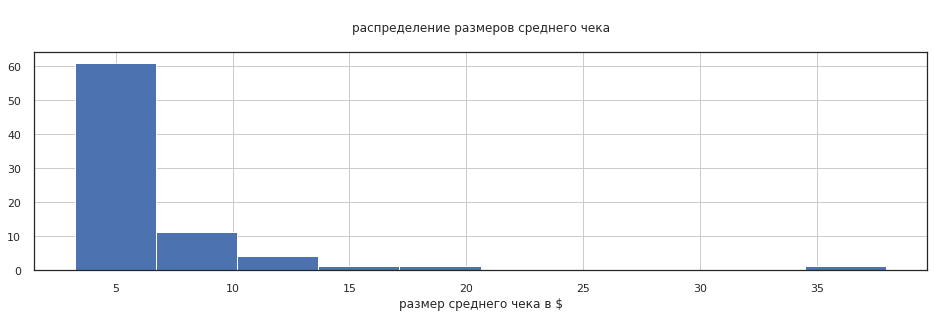


Средний чек в целом по сайту: 5.0 $



In [50]:
orders_grouped_by_cohorts['avg_check'].hist(figsize = (16,4))
plt.title("\n" + 'распределение размеров среднего чека' + "\n")
plt.xlabel('размер среднего чека в $')
plt.show()

print(
        "\n" + 'Средний чек в целом по сайту:',
        round(orders_grouped_by_cohorts.total_revenue.sum() / orders_grouped_by_cohorts.orders.sum(), 2),
        '$' + "\n"
      )

#### Средний чек на разных устройствах

Посмотрим, как средний чек различается на разных устройствах.

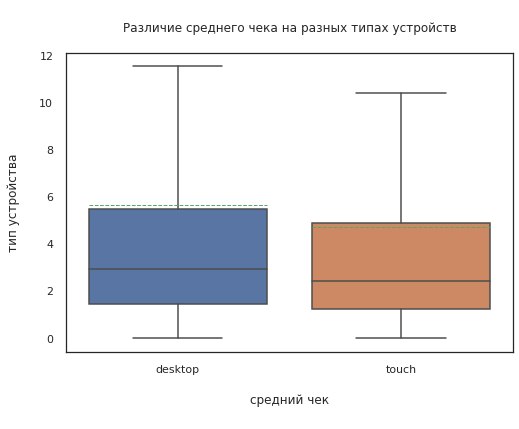

In [51]:
sns.boxplot(
            x = 'device',
            y = 'revenue',
            data = orders.groupby(['order_time']).agg({'device':'first','revenue':'sum'}),
            showfliers = False,
            showmeans = True,
            meanline = True
            )

plt.title("\n" + 'Различие среднего чека на разных типах устройств' + "\n")
plt.xlabel("\n" + 'средний чек' + "\n")
plt.ylabel("тип устройства" + "\n")
plt.show()

#### Средний чек по разным рекламным каналам

Посмотрим, как средний чек различается у людей пришедших с разных рекламных каналов.

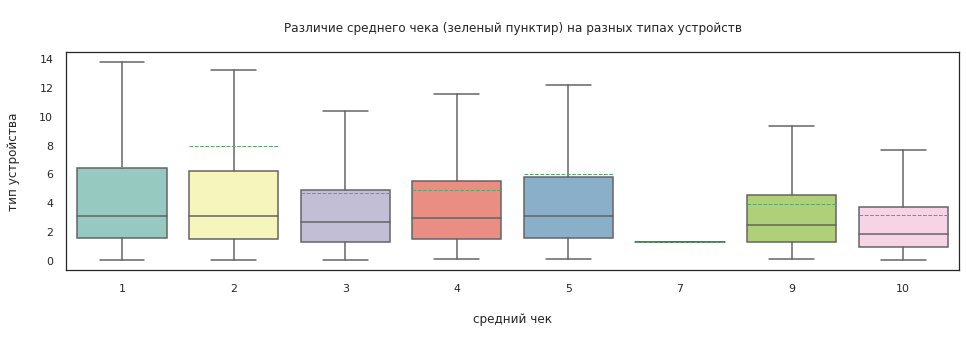

In [52]:
plt.figure(figsize=(16, 4))
sns.boxplot(
            x = 'source_id',
            y = 'revenue',
            data = orders.groupby(['order_time']).agg({'source_id':'first','revenue':'sum'}),
            showfliers = False,
            showmeans = True,
            meanline = True,
            palette = 'Set3'
            )

plt.title("\n" + 'Различие среднего чека (зеленый пунктир) на разных типах устройств' + "\n")
plt.xlabel("\n" + 'средний чек' + "\n")
plt.ylabel("тип устройства" + "\n")
plt.show()

#### Динамика среднего чека

Далее изучим, как меняется средний чек со временем.

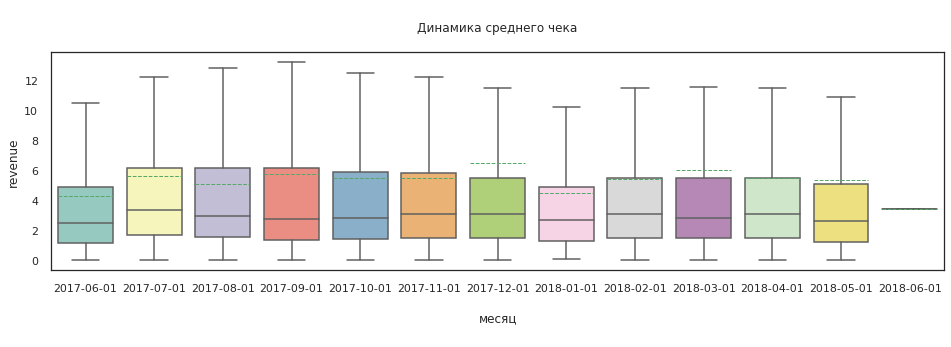

In [53]:
plt.figure(figsize=(16, 4))
sns.boxplot(
            x = 'order_month',
            y = 'revenue',
            data = orders.groupby(['order_time']).agg({'order_month':'first','revenue':'sum'}),
            showfliers = False,
            showmeans = True,
            meanline = True,
            palette = 'Set3'
            )

plt.title("\n" + 'Динамика среднего чека' + "\n")
plt.xlabel("\n" + 'месяц' + "\n")
plt.show()

#### Средний чек по когортам

Изучим, как средний чек меняется в разных когортах.

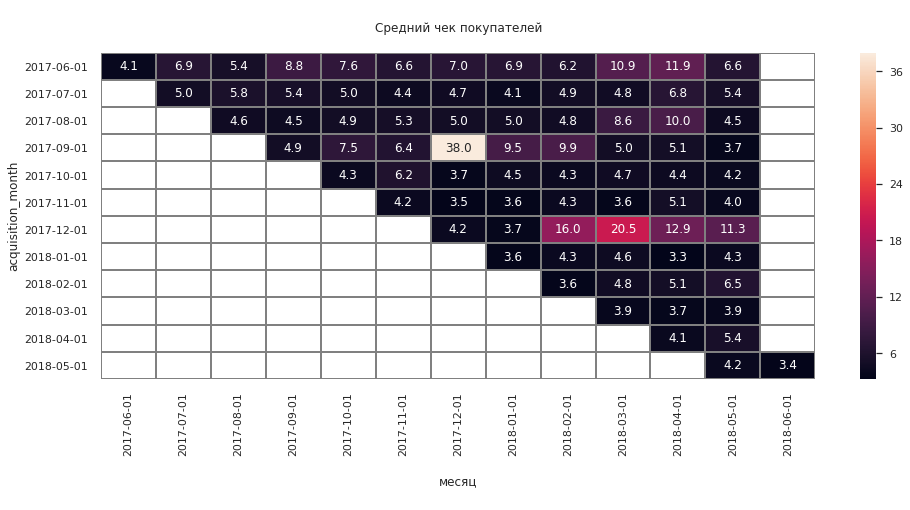

In [54]:
avg_revenue = orders_grouped_by_cohorts.pivot_table(
                                        index='acquisition_month',
                                        columns='order_month',
                                        values='avg_check',
                                        aggfunc='mean')

plt.figure(figsize=(16, 6))

sns.heatmap(avg_revenue, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.title("\n" + 'Средний чек покупателей' + "\n")
plt.xlabel("\n" + 'месяц' + "\n")
plt.show()

**Выводы:**
1. средний чек в целом по сайту — 6 $
2. 


### Сколько раз покупают за период?

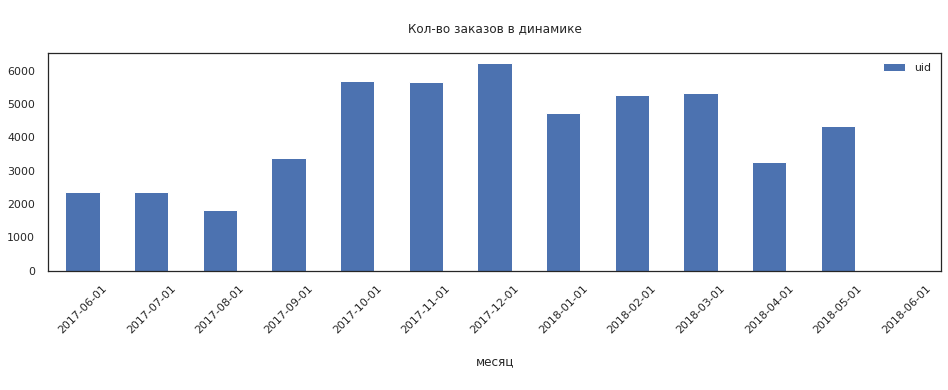


Средний кол-во заказов в месяц: 3878.1 



In [55]:
orders.groupby('order_month').agg({'uid':'count'}).plot(kind = 'bar', figsize = (16,4), rot = 45)
plt.title("\n" + 'Кол-во заказов в динамике' + "\n")
plt.xlabel("\n" + 'месяц' + "\n")
plt.show()


print(
        "\n" + 'Средний кол-во заказов в месяц:',
        round(orders.groupby('order_month')['uid'].count().mean(), 1),
        "\n"
      )

Узнаем сколько в среднем один пользователь делает заказов в месяц.

In [56]:
orders_per_buyer = orders.groupby('order_month').agg({'uid': 'nunique', 'order_time': 'count'})
orders_per_buyer = orders_per_buyer.rename(columns = {'uid': 'buyers', 'order_time': 'orders'})
orders_per_buyer['orders_per_buyer'] = orders_per_buyer['orders'] / orders_per_buyer['buyers']

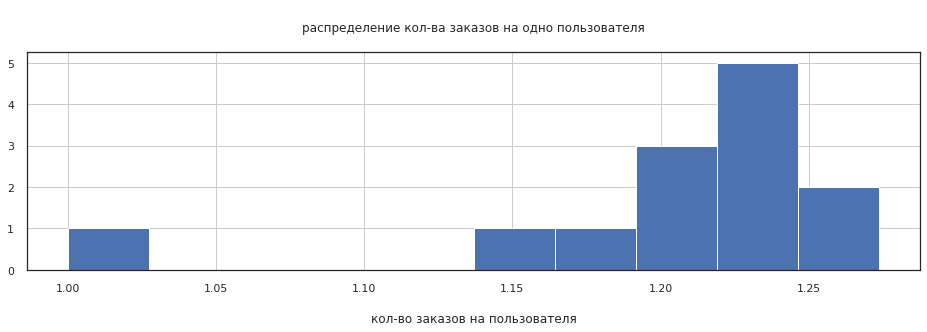


среднее кол-во заказов на одного пользователя в месяц: 1.23 



In [57]:
orders_per_buyer['orders_per_buyer'].hist(figsize = (16,4))
plt.title("\n" + 'распределение кол-ва заказов на одно пользователя' + "\n")
plt.xlabel("\n" + 'кол-во заказов на пользователя')
plt.show()

print(
        "\n" + 'среднее кол-во заказов на одного пользователя в месяц:',
        round(orders_per_buyer.orders.sum() / orders_per_buyer.buyers.sum(), 2), "\n"
      )

В среднем один пользователь делает не больше одной покупки в месяц.

### Сколько денег приносят когорты? (LTV)

#### Выручка с каждой когорты в динамике

In [58]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['acquisition_month']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
orders_grouped_by_cohorts.head()

,acquisition_month,order_month,n_buyers,orders,total_revenue,avg_check,cohort_lifetime
0,2017-06-01,2017-06-01,2023,2354,9557.49,4.06,0
1,2017-06-01,2017-07-01,231,387,2664.58,6.89,1
2,2017-06-01,2017-08-01,129,273,1464.69,5.37,2
3,2017-06-01,2017-09-01,188,442,3882.09,8.78,3
4,2017-06-01,2017-10-01,257,516,3940.59,7.64,4


In [59]:
revenue_per_month = (orders_grouped_by_cohorts
                               .pivot_table(index='acquisition_month',
                                            columns='order_month',
                                            values='total_revenue',
                                            aggfunc='sum')
      )

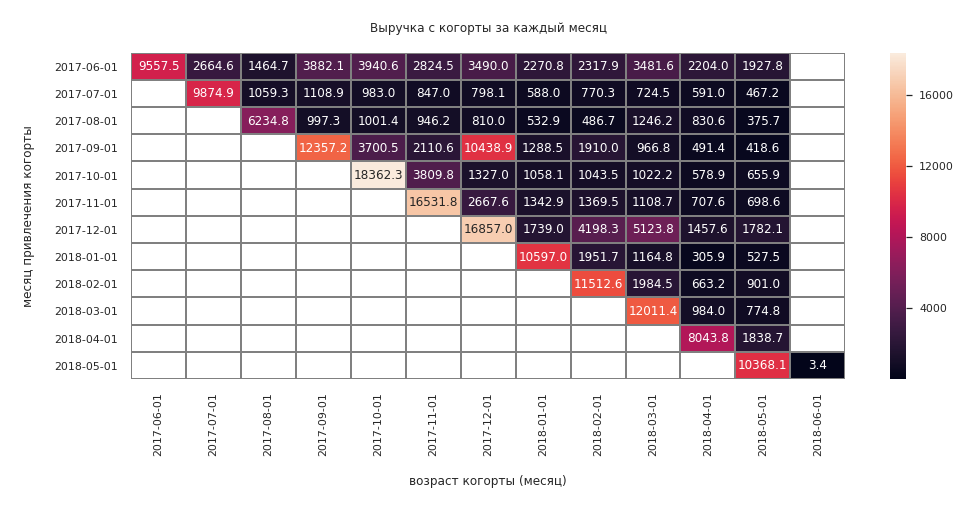


Средний доход с одной когорты по её возрасту:


order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
средний доход,9557.49,6269.73,2919.59,4586.38,5597.54,4511.65,5198.37,2427.14,2840.06,2883.46,1532.55,1728.00,3.42


In [60]:
plt.figure(figsize=(16, 6))

sns.heatmap(revenue_per_month, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.title("\n" + 'Выручка с когорты за каждый месяц' + "\n")
plt.ylabel("\n" + 'месяц привлечения когорты' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()
print("\n" + 'Средний доход с одной когорты по её возрасту:')
pd.DataFrame(revenue_per_month.mean().to_frame(name = 'средний доход')).T.round(2)

#### Средняя выручка с одного клиента в когорте (LTV)

Посмотрим на средний LTV с одного покупателя в когорте.

In [61]:
cohort_sizes = orders.groupby('acquisition_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['acquisition_month', 'n_buyers']
cohort_sizes.head()

,acquisition_month,n_buyers
0,2017-06-01,2923
1,2017-07-01,2458
2,2017-08-01,1721
3,2017-09-01,3058
4,2017-10-01,4678


In [62]:
cohorts = orders.groupby(['acquisition_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,acquisition_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,2664.58
2,2017-06-01,2017-08-01,1464.69
3,2017-06-01,2017-09-01,3882.09
4,2017-06-01,2017-10-01,3940.59


In [63]:
ltv_by_user = pd.merge(cohort_sizes, cohorts, on='acquisition_month')

ltv_by_user['age'] = (ltv_by_user['order_month'] - ltv_by_user['acquisition_month']) / np.timedelta64(1, 'M')
ltv_by_user['age'] = ltv_by_user['age'].round().astype('int')
ltv_by_user['ltv'] = ltv_by_user['revenue'] / ltv_by_user['n_buyers']

ltv_by_user['acquisition_month'] = ltv_by_user['acquisition_month'].astype('datetime64[M]').dt.date
ltv_by_user['order_month'] = ltv_by_user['order_month'].astype('datetime64[M]').dt.date

ltv_by_user.head()

,acquisition_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2923,2017-06-01,9557.49,0,3.27
1,2017-06-01,2923,2017-07-01,2664.58,1,0.91
2,2017-06-01,2923,2017-08-01,1464.69,2,0.50
3,2017-06-01,2923,2017-09-01,3882.09,3,1.33
4,2017-06-01,2923,2017-10-01,3940.59,4,1.35


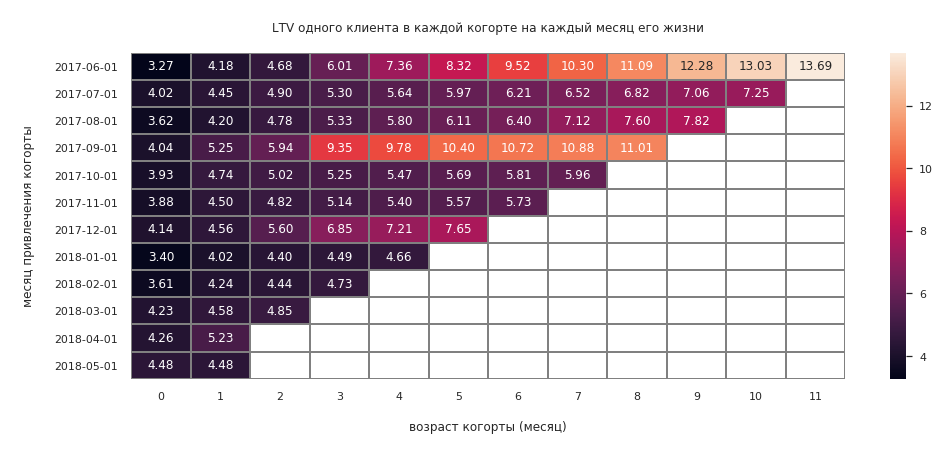

In [64]:
ltv_by_user_pivot = ltv_by_user.pivot_table(
        index='acquisition_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').cumsum(axis=1)
    
plt.figure(figsize=(16, 6))

sns.heatmap(ltv_by_user_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title("\n" + 'LTV одного клиента в каждой когорте на каждый месяц его жизни' + "\n")
plt.ylabel("\n" + 'месяц привлечения когорты' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

#### Как LTV различается на разных  устройствах?

In [65]:
buyers_cohorts = (buyers_info.groupby('device')
                  .agg({'source_id': 'count', 'cac': 'sum'})
                  .rename(columns = {'source_id': 'cohort_size'})
                 )
buyers_cohorts

,cohort_size,cac
device,,
desktop,29211,263183.05
touch,7312,64032.41


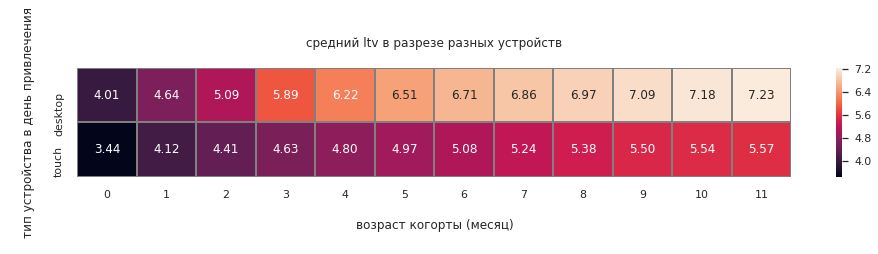

In [66]:
ltv_by_device = orders
ltv_by_device['cohort_age'] = (
                                (ltv_by_device['order_month']
                                   - ltv_by_device['acquisition_month'])
                                / np.timedelta64(1,'M')
                                )
ltv_by_device['cohort_age'] = ltv_by_device['cohort_age'].round().astype('int')
ltv_by_device = (ltv_by_device
                 .groupby(['device', 'cohort_age'])
                          .agg({'revenue': 'sum'})
                )

ltv_by_device = ltv_by_device.pivot_table(index = 'device',
                                          columns = 'cohort_age',
                                          values = 'revenue',
                                          aggfunc = 'sum'
                                         ).cumsum(axis = 1)

ltv_by_device = buyers_cohorts[['cohort_size']].join(ltv_by_device)
ltv_by_device = (ltv_by_device
                 .div(ltv_by_device['cohort_size'], axis = 0)
                 .drop(columns = 'cohort_size')
                )
    
plt.figure(figsize=(16, 2))

sns.heatmap(ltv_by_device, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title("\n" + 'средний ltv в разрезе разных устройств' + "\n")
plt.ylabel("\n" + 'тип устройства в день привлечения' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

#### Как LTV различается у пользователей из разных источников трафика?

In [67]:
buyers_cohorts_by_source = (orders.groupby('source_id')
                  .agg({'device': 'count', 'cac': 'sum'})
                  .rename(columns = {'device': 'cohort_size'})
                 )
buyers_cohorts_by_source

,cohort_size,cac
source_id,,
1,5223,33746.27
2,6392,75878.13
3,13289,176874.66
4,12895,76647.43
5,9406,70507.24
7,1,0.00
9,1647,5892.03
10,1562,6232.31


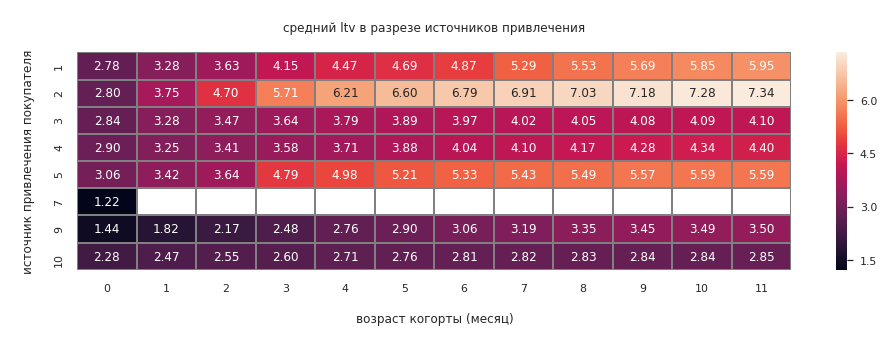

In [68]:
ltv_by_source = orders
ltv_by_source['cohort_age'] = (
                                (ltv_by_source['order_month']
                                   - ltv_by_source['acquisition_month'])
                                / np.timedelta64(1,'M')
                                )
ltv_by_source['cohort_age'] = ltv_by_source['cohort_age'].round().astype('int')
ltv_by_source = (ltv_by_source
                 .groupby(['source_id', 'cohort_age'])
                          .agg({'revenue': 'sum'})
                )

ltv_by_source = ltv_by_source.pivot_table(index = 'source_id',
                                          columns = 'cohort_age',
                                          values = 'revenue',
                                          aggfunc = 'sum'
                                         ).cumsum(axis = 1)

ltv_by_source = buyers_cohorts_by_source[['cohort_size']].join(ltv_by_source)
ltv_by_source = (ltv_by_source
                 .div(ltv_by_source['cohort_size'], axis = 0)
                 .drop(columns = 'cohort_size')
                )


plt.figure(figsize=(16, 4))

sns.heatmap(ltv_by_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title("\n" + 'средний ltv в разрезе источников привлечения' + "\n")
plt.ylabel("\n" + 'источник привлечения покупателя' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

### Метрики маркетинга

**Чек-лист:**
- [x] Сколько всего денег потратили?
- [x] Сколько денег потратили в разрезе разных периодов (по времени)?
- [x] Сколько денег потратили в разрезе разных источников?
- [x] Сколько стоило привлечение одного покупателя из каждого источника?
- [x] На сколько окупились расходы? (ROI)

#### Сколько всего потратили денег? Сколько потратили в разрезе разных периодов?

In [69]:
costs['month'] = costs['acquisition_day'].astype('datetime64[M]')
monthly_costs = costs.groupby('month')['costs'].sum().reset_index()
monthly_costs['month'] = monthly_costs['month'].dt.date
monthly_costs.head(15)

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


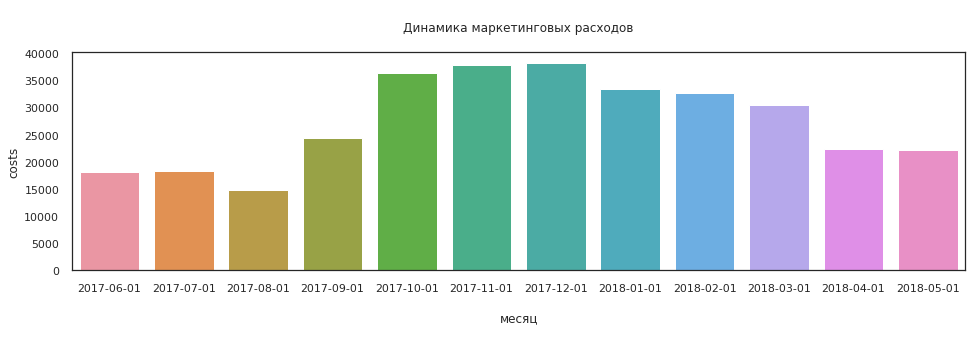

За весь период на привлечение пользователей потратили: 329131.62 $

Средний расход на маркетинг за месяц: 27427.63 $



In [70]:
plt.figure(figsize=(16, 4))
sns.barplot(data=monthly_costs, 
            x ="month",
            y="costs", 
            ci= None)
plt.title("\n" + 'Динамика маркетинговых расходов' + "\n")
plt.xlabel("\n" + 'месяц' + "\n")
plt.show()

print('За весь период на привлечение пользователей потратили:', round(monthly_costs.costs.sum(), 2), '$' + "\n")
print('Средний расход на маркетинг за месяц:', round(monthly_costs.costs.mean(), 2), '$' + "\n")

#### Сколько денег потратили на каждый источник?

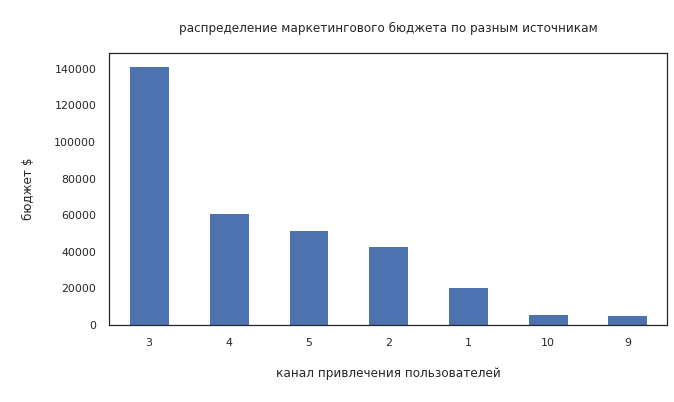

In [71]:
costs_by_source = costs.groupby('source_id').agg({'costs': 'sum'})
costs_by_source.sort_values('costs', ascending = False).costs.plot(kind = 'bar', figsize = (10,5), rot = 0)
plt.title("\n" + 'распределение маркетингового бюджета по разным источникам' + "\n")
plt.ylabel("\n" + 'бюджет $' + "\n")
plt.xlabel("\n" + 'канал привлечения пользователей' + "\n")
plt.show()

#### Сколько стоило привлечение одного покупателя из разных источников?

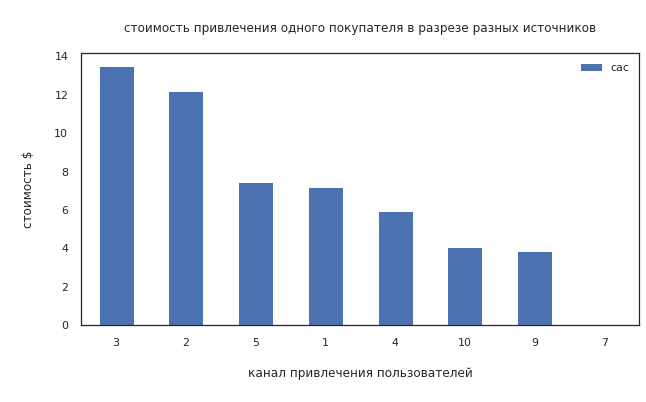

In [72]:
(buyers_info
             .groupby('source_id')
             .agg({'cac': 'mean'})
             .sort_values('cac', ascending = False)
             .plot(kind = 'bar', figsize = (10,5), rot = 0)
)

plt.title("\n" + 'стоимость привлечения одного покупателя в разрезе разных источников' + "\n")
plt.ylabel("\n" + 'стоимость $' + "\n")
plt.xlabel("\n" + 'канал привлечения пользователей' + "\n")
plt.show()

Посмотрим на средний чек за весь период.

In [73]:
user_cost = monthly_costs.merge(cohort_sizes, how = 'left', right_on ='acquisition_month', left_on = 'month')
user_cost['cac'] = user_cost['costs'] / user_cost['n_buyers']
user_cost = user_cost.drop(columns=['acquisition_month'])
user_cost.head()

,month,costs,n_buyers,cac
0,2017-06-01,18015.00,2923,6.16
1,2017-07-01,18240.59,2458,7.42
2,2017-08-01,14790.54,1721,8.59
3,2017-09-01,24368.91,3058,7.97
4,2017-10-01,36322.88,4678,7.76


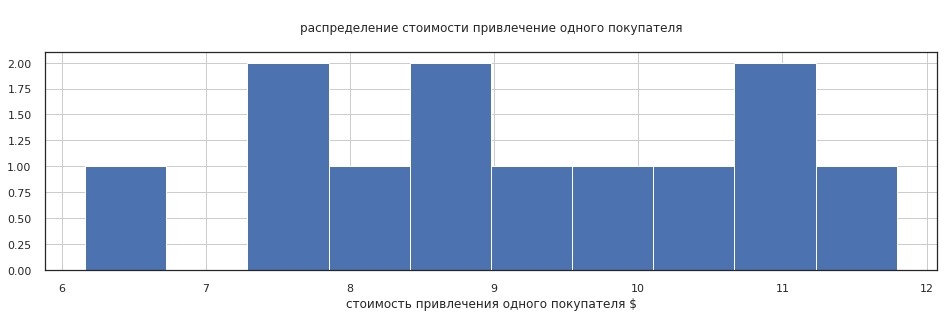


Средняя стоимость привлечения одно покупателя: 9.01 $



In [74]:
user_cost.cac.hist(figsize = (16,4))
plt.title("\n" + 'распределение стоимости привлечение одного покупателя' + "\n")
plt.xlabel('стоимость привлечения одного покупателя $')
plt.show()

print("\n" + 'Средняя стоимость привлечения одно покупателя:', round(user_cost.costs.sum() / user_cost.n_buyers.sum(), 2), '$' + "\n")

#### На сколько окупились расходы? (ROMI)

In [75]:
kek = buyers_info.groupby('device').agg({'revenue': 'sum', 'cac': 'sum'})
kek = kek.rename(columns = {'cac': 'costs'})

In [76]:
kek['romi'] = (kek['revenue'] - kek['costs']) / kek['costs']
kek

,revenue,costs,romi
device,,,
desktop,211329.77,263183.05,-0.20
touch,40727.43,64032.41,-0.36


In [77]:
lol = buyers_info.groupby('source_id').agg({'revenue': 'sum', 'cac': 'sum'})
lol = lol.rename(columns = {'cac': 'costs'})
lol['romi'] = (lol['revenue'] - lol['costs']) / lol['costs']
lol

,revenue,costs,romi
source_id,,,
1,31090.55,20790.03,0.50
2,46923.61,42690.36,0.10
3,54511.24,141321.63,-0.61
4,56696.83,61057.91,-0.07
5,52624.02,51756.40,0.02
7,1.22,0.00,inf
9,5759.40,4197.85,0.37
10,4450.33,5401.28,-0.18


In [78]:
report_new = ltv_by_user.merge(user_cost, left_on='acquisition_month', right_on='month')
report_new = report_new.drop(columns=['n_buyers_y'])
report_new = report_new.rename(columns = {'n_buyers_x': 'n_buyers'})
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new.head() 

,acquisition_month,n_buyers,order_month,revenue,age,ltv,month,costs,cac,romi
0,2017-06-01,2923,2017-06-01,9557.49,0,3.27,2017-06-01,18015.00,6.16,0.53
1,2017-06-01,2923,2017-07-01,2664.58,1,0.91,2017-06-01,18015.00,6.16,0.15
2,2017-06-01,2923,2017-08-01,1464.69,2,0.50,2017-06-01,18015.00,6.16,0.08
3,2017-06-01,2923,2017-09-01,3882.09,3,1.33,2017-06-01,18015.00,6.16,0.22
4,2017-06-01,2923,2017-10-01,3940.59,4,1.35,2017-06-01,18015.00,6.16,0.22


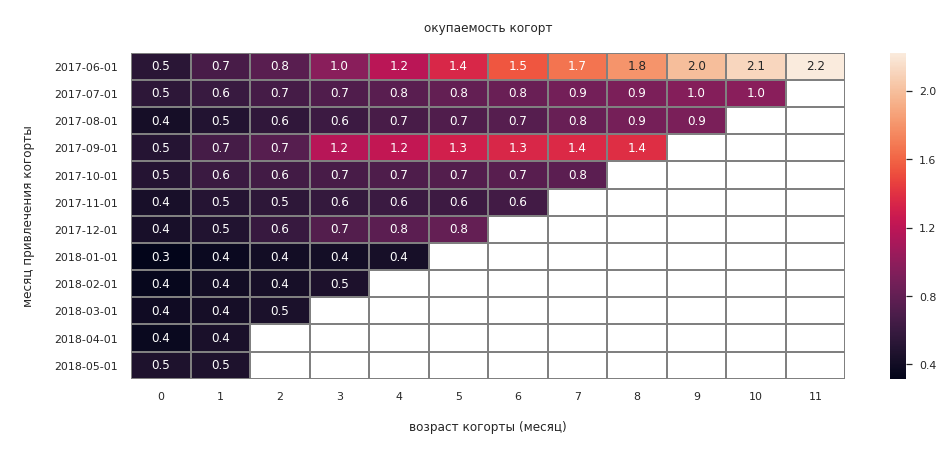


Итоговый ROMI: -23.42


In [79]:
romi_pivot = report_new.pivot_table(
        index='acquisition_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1)


plt.figure(figsize=(16, 6))

sns.heatmap(romi_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.title("\n" + 'окупаемость когорт' + "\n")
plt.ylabel("\n" + 'месяц привлечения когорты' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

print("\n" + 'Итоговый ROMI:', round((orders.revenue.sum() - costs.costs.sum()) / costs.costs.sum() * 100, 2))

#### На сколько окупились расходы на каждый источник трафика?

In [80]:
buyers_cohorts_by_source

,cohort_size,cac
source_id,,
1,5223,33746.27
2,6392,75878.13
3,13289,176874.66
4,12895,76647.43
5,9406,70507.24
7,1,0.00
9,1647,5892.03
10,1562,6232.31


In [81]:
costs_by_source

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


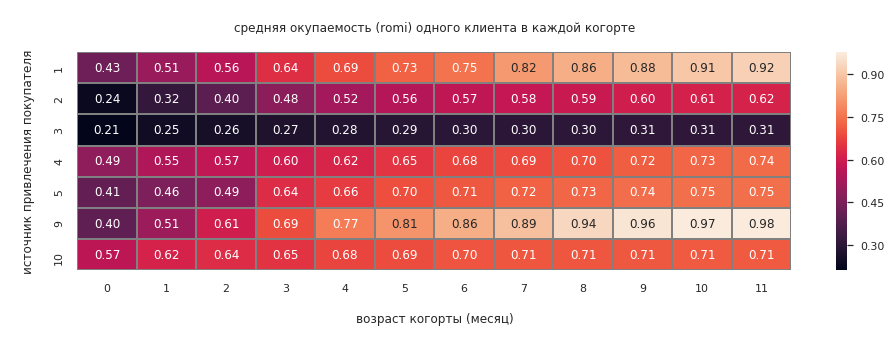

In [82]:
romi_by_source = ltv_by_source.merge(buyers_cohorts_by_source, on = 'source_id', how = 'left')
romi_by_source['romi'] = romi_by_source['cac'] / romi_by_source['cohort_size']
romi_by_source = (romi_by_source
                 .div(romi_by_source['romi'], axis = 0)
                 .drop(columns = ['cohort_size', 'cac', 'romi'])
                 .drop(index = 7)
                )

plt.figure(figsize=(16, 4))

sns.heatmap(romi_by_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title("\n" + 'средняя окупаемость (romi) одного клиента в каждой когорте' + "\n")
plt.ylabel("\n" + 'источник привлечения покупателя' + "\n")
plt.xlabel("\n" + 'возраст когорты (месяц)' + "\n")
plt.show()

### Выводы <a id="conclusion2"></a>
[В начало шага](#Шаг_2)

***

## Шаг 3. Выводы и рекомендации <a id="Шаг_3"></a>
[К оглавлению](#оглавление)<br>
+ Куда и сколько им стоит вкладывать денег? 
+ Какие источники/платформы вы бы порекомендовали?

Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?
